In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import time
from CCF import CCF

tf.logging.set_verbosity(tf.logging.DEBUG)
tf.reset_default_graph()
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

C:\Users\user\anaconda3\envs\tf_1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\anaconda3\envs\tf_1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\anaconda3\envs\tf_1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user\anaconda3\envs\tf_1.14\lib\site-packages\tensorflow\pyth

In [2]:
all_ckpt = 'MM1G_ckpt/'  # MM1G: multiple model 1 graph
model = 'model_MM1G' + '.ckpt'  # 'model_MM1G.ckpt'

if not os.path.isdir(all_ckpt):
    os.mkdir(all_ckpt)

if not os.path.isdir(all_ckpt + 'vars_select'):
    os.mkdir(all_ckpt + 'vars_select')

saver_path = os.path.join(all_ckpt, model)  # 'MM1G_ckpt\\model_MM1G.ckpt'

restore_path = os.path.join(all_ckpt)

pb_name = 'model_FaultDetective_MM1G' + '_HeatControl'  # 'model_FaultDetective_xxxx_HeatControl'
pb_tag = 'mytag_FaultDetective_MM1G' + '_HeatControl'  # 'mytag_FaultDetective_xxxx_HeatControl'
pb_path = os.path.join(all_ckpt, pb_name)

In [3]:
data = pd.read_csv('electrity_data_select.csv')
data = data.iloc[:,2:]
print(data.shape)

data_1 = data.iloc[:,:10]
data_2 = data.iloc[:,-1]
data = pd.concat([data_1, data_2], axis=1)
print(data.shape)


(864, 12)
(864, 11)


In [4]:
data_train = data.iloc[0:600,:] 
data_valid = data.iloc[600:700,:]
data_test = data.iloc[700:,:]

In [5]:
CCFtrain=CCF(data_train,maxlag=0)
CCFtrain.cal()
# CCFtrain.show()

In [6]:
'''
功能:找出"欲檢測變量"的index
input:
    data_train_feature: 所有變量的index
    var_index_all: 欲檢測變量(string)
output:
    var_index: "欲檢測變量"的index
    ele: "欲檢測變量"的名稱
'''

def find_feature_index(data_train_feature, var_index_all):
    var_num_all = []
    ele_all = []

    # "欲檢測變量" index
    for index, ele in enumerate(var_index_all):
        var_index = data_train_feature.get_loc(var_index_all[index])
#         ele = int(ele)
        var_num_all.append(var_index)
        ele_all.append(ele)

    var_num_all = np.array(var_num_all).reshape(-1)
    ele_all = np.array(ele_all).reshape(-1)

    return var_num_all, ele_all

In [7]:
data_train_feature = data_train.iloc[:,0:].keys()
var_index_all = ['sun_battary_current1','sun_battary_current4','sun_battary_current8',
                 'main_remote_voltage','main_remote_current', 'B_battary_voltage']
var_num_all, ele_all = find_feature_index(data_train_feature, var_index_all)


In [8]:
'''重要變量: 挑選跟'xxxx'較相關的變量，再找出他們的index'''

feature_select_1 = np.array(CCFtrain.select('sun_battary_current1',0.1,0.9))
feature_index_1, feature_ele_1 = find_feature_index(data_train_feature, feature_select_1)
label_index_1 = data_train_feature.get_loc('sun_battary_current1')

feature_select_2 = np.array(CCFtrain.select('sun_battary_current4',0.1,0.9))
feature_index_2, feature_ele_2 = find_feature_index(data_train_feature, feature_select_2)
label_index_2 = data_train_feature.get_loc('sun_battary_current4')

feature_select_3 = np.array(CCFtrain.select('sun_battary_current8',0.1,0.9))
feature_index_3, feature_ele_3 = find_feature_index(data_train_feature, feature_select_3)
label_index_3 = data_train_feature.get_loc('sun_battary_current8')

feature_select_4 = np.array(CCFtrain.select('main_remote_voltage',0.1,0.9))
feature_index_4, feature_ele_4 = find_feature_index(data_train_feature, feature_select_4)
label_index_4 = data_train_feature.get_loc('main_remote_voltage')

feature_select_5 = np.array(CCFtrain.select('main_remote_current',0.1,0.9))
feature_index_5, feature_ele_5 = find_feature_index(data_train_feature, feature_select_5)
label_index_5 = data_train_feature.get_loc('main_remote_current')

feature_select_6 = np.array(CCFtrain.select('B_battary_voltage',0.1,0.9))
feature_index_6, feature_ele_6 = find_feature_index(data_train_feature, feature_select_6)
label_index_6 = data_train_feature.get_loc('B_battary_voltage')

In [9]:
'''普通變量: 輸入所有普通變量，輸出所有普通變量'''

##### 先挑出所有普通變量 #####
vital_vars = ['sun_battary_current1','sun_battary_current4','sun_battary_current8',
                 'main_remote_voltage','main_remote_current', 'B_battary_voltage']  # 10
normal_vars = []

for i in data_train_feature:
    temp = 0
    for j in vital_vars:
        if i != j:
            temp = temp + 1

    if temp == len(vital_vars):
        normal_vars.append(i)

In [10]:
##### 求所有普通變量index #####
feature_index_normal, feature_ele_normal = find_feature_index(data_train_feature, normal_vars)

In [11]:
feature_ele_normal

array(['sun_battary_current2', 'sun_battary_current3',
       'sun_battary_current5', 'sun_battary_current6',
       'sun_battary_current7'], dtype='<U20')

In [12]:
'''標準化'''
data_mean = np.mean(np.array(data_train.iloc[:,0:]),0)
data_std = np.std(np.array(data_train.iloc[:,0:]),0,ddof=1)

data_train = (data_train - data_mean)/data_std
data_valid = (data_valid - data_mean)/data_std
data_test = (data_test - data_mean)/data_std

In [13]:
# 提取data_mean、data_std 重要變量對應的index，以利反轉

feature_index_vital, _ = find_feature_index(data_train_feature, vital_vars)

mean_vital = []
std_vital = []

for i in feature_index_vital:
#     print(i)
    mean_vital.append(data_mean[i])
    std_vital.append(data_std[i])
mean_vital = np.array(mean_vital)
std_vital = np.array(std_vital)

data_train = data_train.values
data_valid = data_valid.values
data_test = data_test.values

In [14]:
def add_window_(time_series, time_step, multiply):
    
    series_window_multiply = []
    L = len(time_series)

    for i in range(L-time_step):
        dat = time_series[i:i+time_step]
        for j in range(multiply):
            series_window_multiply.append(dat)
    
    series_window_multiply = np.array(series_window_multiply)
    
    return series_window_multiply

In [15]:
nsteps = 1
multiply = 1      # 相當於batch_size

''' TRAIN '''
#feature
data_train_window = add_window_(data_train, nsteps, multiply)
# print(data_train_window.shape)

''' VALID '''
#feature
data_valid_window = add_window_(data_valid, nsteps, multiply)
# print(data_valid_window.shape)

''' TEST '''
#feature
data_test_window = add_window_(data_test, nsteps, multiply)
# print(data_test_window.shape)

# training parameters
dim_input = data_train_window.shape[-1] #data特徵數
timestep = data_train_window.shape[1]
num_input_1 = feature_index_1.shape[0]
num_input_2 = feature_index_2.shape[0]
num_input_3 = feature_index_3.shape[0]
num_input_4 = feature_index_4.shape[0]
num_input_5 = feature_index_5.shape[0]
num_input_6 = feature_index_6.shape[0]
num_input_normal = feature_index_normal.shape[0]


In [16]:
def draw_during_train(output_real, output_pred, mean_vital, std_vital):
    output_real_ = np.array(output_real).reshape((-1, dim_input))
    output_real_ = output_real_[:, :len(std_vital)]
    output_real_ = (output_real_ * std_vital) + mean_vital

    output_pred_ = np.array(output_pred).reshape((-1, dim_input))
    output_pred_ = output_pred_[:, :len(std_vital)]
    output_pred_ = (output_pred_ * std_vital) + mean_vital

    for i in range(len(var_num_all)):
        plt.figure(i)
        plt.plot(output_real_[:, i], 'y')
        plt.plot(output_pred_[:, i])
        plt.ylabel('var_' + str(ele_all[i]))
        plt.show()


def draw_during_valid(output_real, output_pred, mean_vital, std_vital):
    output_real_ = np.array(output_real).reshape((-1, dim_input))
    output_real_ = output_real_[:, :len(std_vital)]
    output_real_ = (output_real_ * std_vital) + mean_vital

    output_pred_ = np.array(output_pred).reshape((-1, dim_input))
    output_pred_ = output_pred_[:, :len(std_vital)]
    output_pred_ = (output_pred_ * std_vital) + mean_vital

    for i in range(len(var_num_all)):
        plt.figure(i)
        plt.plot(output_real_[:, i], 'r')
        plt.plot(output_pred_[:, i])
        plt.ylabel('var_' + str(ele_all[i]))
        plt.show()


def draw_during_test(output_real, output_pred, mean_vital, std_vital):
    output_real_ = np.array(output_real).reshape((-1, dim_input))
    output_real_ = output_real_[:, :len(std_vital)]
    output_real_ = (output_real_ * std_vital) + mean_vital

    output_pred_ = np.array(output_pred).reshape((-1, dim_input))
    output_pred_ = output_pred_[:, :len(std_vital)]
    output_pred_ = (output_pred_ * std_vital) + mean_vital

    for i in range(len(var_num_all)):
        plt.figure(i)
        plt.plot(output_real_[:, i], 'g')
        plt.plot(output_pred_[:, i])
        plt.ylabel('var_' + str(ele_all[i]))
        plt.show()


def draw_final_train(output_real, output_pred, mean_vital, std_vital):
    output_real_ = np.array(output_real).reshape((-1, dim_input))
    output_real_ = output_real_[:, :len(std_vital)]
    output_real_ = (output_real_ * std_vital) + mean_vital

    output_pred_ = np.array(output_pred).reshape((-1, dim_input))
    output_pred_ = output_pred_[:, :len(std_vital)]
    output_pred_ = (output_pred_ * std_vital) + mean_vital

    for i in range(len(var_num_all)):
        plt.figure(i * 2)
        fig = plt.figure(figsize=(12, 8))
        plt.plot(output_pred_[:, i], label='pred')
        plt.plot(output_real_[:, i], 'y', linestyle='dashed', label='true')
        plt.title('pred v.s real')
        plt.ylabel('var_' + str(ele_all[i]))
        plt.legend()
        plt.show()


def draw_final_valid(output_real, output_pred, mean_vital, std_vital):
    output_real_ = np.array(output_real).reshape((-1, dim_input))
    output_real_ = output_real_[:, :len(std_vital)]
    output_real_ = (output_real_ * std_vital) + mean_vital

    output_pred_ = np.array(output_pred).reshape((-1, dim_input))
    output_pred_ = output_pred_[:, :len(std_vital)]
    output_pred_ = (output_pred_ * std_vital) + mean_vital

    for i in range(len(var_num_all)):
        plt.figure(i * 2)
        fig = plt.figure(figsize=(12, 8))
        plt.plot(output_pred_[:, i], label='pred')
        plt.plot(output_real_[:, i], 'r', linestyle='dashed', label='true')
        plt.title('pred v.s real')
        plt.ylabel('var_' + str(ele_all[i]))
        plt.legend()
        plt.show()


def draw_final_test(output_real, output_pred, mean_vital, std_vital):
    output_real_ = np.array(output_real).reshape((-1, dim_input))
    output_real_ = output_real_[:, :len(std_vital)]
    output_real_ = (output_real_ * std_vital) + mean_vital

    output_pred_ = np.array(output_pred).reshape((-1, dim_input))
    output_pred_ = output_pred_[:, :len(std_vital)]
    output_pred_ = (output_pred_ * std_vital) + mean_vital

    for i in range(len(var_num_all)):
        plt.figure(i * 2)
        fig = plt.figure(figsize=(12, 8))
        plt.plot(output_pred_[:, i], label='pred')
        plt.plot(output_real_[:, i], 'g', linestyle='dashed', label='true')
        plt.title('pred v.s real')
        plt.ylabel('var_' + str(ele_all[i]))
        plt.legend()
        plt.show()

In [17]:
def vars_select(x_train, feature_select_index, label_select_index):
    ######################## select features we want ########################
    select_index = feature_select_index
    select_index_shape = tf.shape_n([select_index])
    len_index = select_index_shape[0][0]

    step = tf.constant(0)
    #     index_all = tf.Variable([])
    index_all = tf.Variable([], name='index_all_init')
    index_all = tf.cast(index_all, tf.int32)

    def cond(step, index_all):
        return step < len_index

    def body(step, index_all):
        tmep = tf.gather(select_index, step)
        index_all = tf.concat([index_all, [tmep]], 0)
        step = step + 1

        return step, index_all

    _, index_all = tf.while_loop(cond, body, [step, index_all],
                                 shape_invariants=[step.get_shape(), tf.TensorShape([None])])

    index_all = tf.cast(index_all, tf.int32)
    data_feature_select = tf.gather(x_train, index_all, axis=2)

    ######################## select label we want ########################

    label_select_index = tf.cast(label_select_index, tf.int32)
    data_label_select = tf.gather(x_train, label_select_index, axis=2)

    return data_feature_select, data_label_select


def BP(X, keep_prob_feed, batch_size_feed,
     Feature_Index_1, Label_Index_1,
     Feature_Index_2, Label_Index_2,
     Feature_Index_3, Label_Index_3,
     Feature_Index_4, Label_Index_4,
     Feature_Index_5, Label_Index_5,
     Feature_Index_6, Label_Index_6,
     Feature_Index_normal,
       ):
    with graph_offline.as_default():
        X_1, Y_1 = vars_select(X, Feature_Index_1, Label_Index_1)
        X_2, Y_2 = vars_select(X, Feature_Index_2, Label_Index_2)
        X_3, Y_3 = vars_select(X, Feature_Index_3, Label_Index_3)
        X_4, Y_4 = vars_select(X, Feature_Index_4, Label_Index_4)
        X_5, Y_5 = vars_select(X, Feature_Index_5, Label_Index_5)
        X_6, Y_6 = vars_select(X, Feature_Index_6, Label_Index_6)
        X_normal, _ = vars_select(X, Feature_Index_normal, 0)
        
        with tf.variable_scope("BP", reuse=tf.AUTO_REUSE) as BP:
            ######################### sub_model 1 ###############################################
            x_1 = X_1[0]
            y_1 = Y_1[0]

            hidden_1 = tf.reshape(x_1, (batch_size_feed, timestep, num_input_1))
            hidden_1 = tf.reshape(hidden_1, (batch_size_feed, timestep * num_input_1))

            hidden_1 = tf.layers.dense(hidden_1, units=timestep * 32, activation=tf.nn.relu)
            hidden_1 = tf.layers.dropout(hidden_1, rate=1 - keep_prob_feed)

            hidden_1 = tf.layers.dense(hidden_1, units=timestep * 32, activation=tf.nn.relu)
            hidden_1 = tf.layers.dropout(hidden_1, rate=1 - keep_prob_feed)

            hidden_1 = tf.layers.dense(hidden_1, units=timestep * 16)
            hidden_1 = tf.layers.dropout(hidden_1, rate=1 - keep_prob_feed)

            hidden_1 = tf.layers.dense(hidden_1, units=timestep * 1)
            outputs_1 = tf.layers.dropout(hidden_1, rate=1 - keep_prob_feed)

            outputs_1 = tf.reshape(outputs_1, (batch_size_feed, timestep, -1))
            y_1 = tf.reshape(y_1, (batch_size_feed, timestep, -1))
            
            ######################### sub_model 2 ###############################################
            x_2 = X_2[0]
            y_2 = Y_2[0]

            hidden_2 = tf.reshape(x_2, (batch_size_feed, timestep, num_input_2))
            hidden_2 = tf.reshape(hidden_2, (batch_size_feed, timestep * num_input_2))

            hidden_2 = tf.layers.dense(hidden_2, units=timestep * 32, activation=tf.nn.relu)
            hidden_2 = tf.layers.dropout(hidden_2, rate=1 - keep_prob_feed)

            hidden_2 = tf.layers.dense(hidden_2, units=timestep * 32, activation=tf.nn.relu)
            hidden_2 = tf.layers.dropout(hidden_2, rate=1 - keep_prob_feed)

            hidden_2 = tf.layers.dense(hidden_2, units=timestep * 16)
            hidden_2 = tf.layers.dropout(hidden_2, rate=1 - keep_prob_feed)

            hidden_2 = tf.layers.dense(hidden_2, units=timestep * 1)
            outputs_2 = tf.layers.dropout(hidden_2, rate=1 - keep_prob_feed)

            outputs_2 = tf.reshape(outputs_2, (batch_size_feed, timestep, -1))
            y_2 = tf.reshape(y_2, (batch_size_feed, timestep, -1))   
            
            ######################### sub_model 3 ###############################################
            x_3 = X_3[0]
            y_3 = Y_3[0]

            hidden_3 = tf.reshape(x_3, (batch_size_feed, timestep, num_input_3))
            hidden_3 = tf.reshape(hidden_3, (batch_size_feed, timestep * num_input_3))

            hidden_3 = tf.layers.dense(hidden_3, units=timestep * 32, activation=tf.nn.relu)
            hidden_3 = tf.layers.dropout(hidden_3, rate=1 - keep_prob_feed)

            hidden_3 = tf.layers.dense(hidden_3, units=timestep * 32, activation=tf.nn.relu)
            hidden_3 = tf.layers.dropout(hidden_3, rate=1 - keep_prob_feed)

            hidden_3 = tf.layers.dense(hidden_3, units=timestep * 16)
            hidden_3 = tf.layers.dropout(hidden_3, rate=1 - keep_prob_feed)

            hidden_3 = tf.layers.dense(hidden_3, units=timestep * 1)
            outputs_3 = tf.layers.dropout(hidden_3, rate=1 - keep_prob_feed)

            outputs_3 = tf.reshape(outputs_3, (batch_size_feed, timestep, -1))
            y_3 = tf.reshape(y_3, (batch_size_feed, timestep, -1))  
            
            ######################### sub_model 4 ###############################################
            x_4 = X_4[0]
            y_4 = Y_4[0]

            hidden_4 = tf.reshape(x_4, (batch_size_feed, timestep, num_input_4))
            hidden_4 = tf.reshape(hidden_4, (batch_size_feed, timestep * num_input_4))

            hidden_4 = tf.layers.dense(hidden_4, units=timestep * 32, activation=tf.nn.relu)
            hidden_4 = tf.layers.dropout(hidden_4, rate=1 - keep_prob_feed)

            hidden_4 = tf.layers.dense(hidden_4, units=timestep * 32, activation=tf.nn.relu)
            hidden_4 = tf.layers.dropout(hidden_4, rate=1 - keep_prob_feed)

            hidden_4 = tf.layers.dense(hidden_4, units=timestep * 16)
            hidden_4 = tf.layers.dropout(hidden_4, rate=1 - keep_prob_feed)

            hidden_4 = tf.layers.dense(hidden_4, units=timestep * 1)
            outputs_4 = tf.layers.dropout(hidden_4, rate=1 - keep_prob_feed)

            outputs_4 = tf.reshape(outputs_4, (batch_size_feed, timestep, -1))
            y_4 = tf.reshape(y_4, (batch_size_feed, timestep, -1))  
            
            ######################### sub_model 5 ###############################################
            x_5 = X_5[0]
            y_5 = Y_5[0]

            hidden_5 = tf.reshape(x_5, (batch_size_feed, timestep, num_input_5))
            hidden_5 = tf.reshape(hidden_5, (batch_size_feed, timestep * num_input_5))

            hidden_5 = tf.layers.dense(hidden_5, units=timestep * 32, activation=tf.nn.relu)
            hidden_5 = tf.layers.dropout(hidden_5, rate=1 - keep_prob_feed)

            hidden_5 = tf.layers.dense(hidden_5, units=timestep * 32, activation=tf.nn.relu)
            hidden_5 = tf.layers.dropout(hidden_5, rate=1 - keep_prob_feed)

            hidden_5 = tf.layers.dense(hidden_5, units=timestep * 16)
            hidden_5 = tf.layers.dropout(hidden_5, rate=1 - keep_prob_feed)

            hidden_5 = tf.layers.dense(hidden_5, units=timestep * 1)
            outputs_5 = tf.layers.dropout(hidden_5, rate=1 - keep_prob_feed)

            outputs_5 = tf.reshape(outputs_5, (batch_size_feed, timestep, -1))
            y_5 = tf.reshape(y_5, (batch_size_feed, timestep, -1))  
            
            ######################### sub_model 6 ###############################################
            x_6 = X_6[0]
            y_6 = Y_6[0]

            hidden_6 = tf.reshape(x_6, (batch_size_feed, timestep, num_input_6))
            hidden_6 = tf.reshape(hidden_6, (batch_size_feed, timestep * num_input_6))

            hidden_6 = tf.layers.dense(hidden_6, units=timestep * 32, activation=tf.nn.relu)
            hidden_6 = tf.layers.dropout(hidden_6, rate=1 - keep_prob_feed)

            hidden_6 = tf.layers.dense(hidden_6, units=timestep * 32, activation=tf.nn.relu)
            hidden_6 = tf.layers.dropout(hidden_6, rate=1 - keep_prob_feed)

            hidden_6 = tf.layers.dense(hidden_6, units=timestep * 16)
            hidden_6 = tf.layers.dropout(hidden_6, rate=1 - keep_prob_feed)

            hidden_6 = tf.layers.dense(hidden_6, units=timestep * 1)
            outputs_6 = tf.layers.dropout(hidden_6, rate=1 - keep_prob_feed)

            outputs_6 = tf.reshape(outputs_6, (batch_size_feed, timestep, -1))
            y_6 = tf.reshape(y_6, (batch_size_feed, timestep, -1))     
            
            ######################### sub_model normal ###############################################
            x_normal = X_normal[0]
            y_normal = X_normal[0]

            hidden_normal = tf.reshape(x_normal, (batch_size_feed, timestep, num_input_normal))
            hidden_normal = tf.reshape(hidden_normal, (batch_size_feed, timestep * num_input_normal))

            hidden_normal = tf.layers.dense(hidden_normal, units=timestep * 32, activation=tf.nn.relu)
            hidden_normal = tf.layers.dropout(hidden_normal, rate=1 - keep_prob_feed)

            hidden_normal = tf.layers.dense(hidden_normal, units=timestep * 32, activation=tf.nn.relu)
            hidden_normal = tf.layers.dropout(hidden_normal, rate=1 - keep_prob_feed)

            hidden_normal = tf.layers.dense(hidden_normal, units=timestep * 16)
            hidden_normal = tf.layers.dropout(hidden_normal, rate=1 - keep_prob_feed)

            hidden_normal = tf.layers.dense(hidden_normal, units=timestep * num_input_normal)
            outputs_normal = tf.layers.dropout(hidden_normal, rate=1 - keep_prob_feed)

            outputs_normal = tf.reshape(outputs_normal, (batch_size_feed, timestep, num_input_normal))
            y_normal = tf.reshape(y_normal, (batch_size_feed, timestep, num_input_normal))

            ######################### combine ###############################################

            output_all = tf.concat([outputs_1, outputs_2, outputs_3, outputs_4, outputs_5,
                                    outputs_6, outputs_normal], -1)
            label_all = tf.concat([y_1, y_2, y_3, y_4, y_5,
                                   y_6, y_normal], -1)

    #             output_all = outputs_6144
    #             label_all = y_6144

    return output_all, label_all

In [18]:
graph_offline = tf.Graph()
with graph_offline.as_default():
    # variables : input
    X = tf.placeholder(tf.float32, shape=(None, timestep, dim_input))
    keep_prob_feed = tf.placeholder(tf.float32)
    global_step = tf.Variable(0, trainable=False)
    batch_size_feed = tf.placeholder(tf.int32, [])

    Feature_Index_1 = tf.placeholder(tf.int32, [None])
    Label_Index_1 = tf.placeholder(tf.int32, [])
    Feature_Index_2 = tf.placeholder(tf.int32, [None])
    Label_Index_2 = tf.placeholder(tf.int32, [])
    Feature_Index_3 = tf.placeholder(tf.int32, [None])
    Label_Index_3 = tf.placeholder(tf.int32, [])
    Feature_Index_4 = tf.placeholder(tf.int32, [None])
    Label_Index_4 = tf.placeholder(tf.int32, [])
    Feature_Index_5 = tf.placeholder(tf.int32, [None])
    Label_Index_5 = tf.placeholder(tf.int32, [])
    Feature_Index_6 = tf.placeholder(tf.int32, [None])
    Label_Index_6 = tf.placeholder(tf.int32, [])    
    Feature_Index_normal = tf.placeholder(tf.int32, [None])
    
    lr = 0.0003
    decay_rate = 0.95
    decay_step = 800
    lambda_regularization = 0.0005

    pred, label = BP(X, keep_prob_feed, batch_size_feed,
                     Feature_Index_1, Label_Index_1,
                     Feature_Index_2, Label_Index_2,
                     Feature_Index_3, Label_Index_3,
                     Feature_Index_4, Label_Index_4,
                     Feature_Index_5, Label_Index_5,
                     Feature_Index_6, Label_Index_6,
                     Feature_Index_normal,
                    )

    #### MSE
    cost = tf.losses.mean_squared_error(label, pred)

    # # 正則化: L2
    # T_vars = tf.trainable_variables()
    # lstm_vars = [var for var in T_vars if var.name.startswith('RNN_lstm')]
    # regularization_cost = lambda_regularization* tf.reduce_sum([ tf.nn.l2_loss(v) for v in lstm_vars ])
    # cost_with_regularization = cost + regularization_cost

    # Optimizer
    learning_rate_decayed = lr * decay_rate ** (global_step / decay_step)
    optimizer = tf.train.RMSPropOptimizer(learning_rate_decayed).minimize(cost)
    # optm = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_with_regularization)


Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.dropout instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Optimization start!
Training: [1/600] loss: 0.358
valid : [1/600] loss: 0.095
Training: [2/600] loss: 0.019
valid : [2/600] loss: 0.027
Training: [3/600] loss: 0.005
valid : [3/600] loss: 0.014
Training: [4/600] loss: 0.002
valid : [4/600] loss: 0.007
Training: [5/600] loss: 0.002
valid : [5/600] loss: 0.004
Training: [6/600] loss: 0.001
valid : [6/600] loss: 0.004
Training: [7/600] loss: 0.001
valid : [7/600] loss: 0.003
Training: [8/600] loss: 0.001
valid : [8/600] loss: 0.002
Training: [9/600] loss: 0.001
valid : [9/600] loss: 0.002
Training: [10/600] loss: 0.001
valid : [10/600] loss: 0.002
Training: [11/600] loss: 0.001
valid : [11/600] loss: 0.001
Training: [12/600] loss: 0.001
valid : [12/600] loss: 0.001
Training: [13/600] loss: 0.001
valid : [13/600] loss: 0.001
Training: [14/600] loss: 0.001
valid : [14/600] loss: 0.001
Training: [15/600] loss: 0.001
valid : [15/600] loss: 0.001
Training: [16/600] loss: 0.001
valid : [16/600] loss: 0.001
Training: [17/600] loss: 0.001
valid :

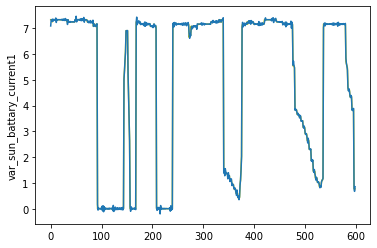

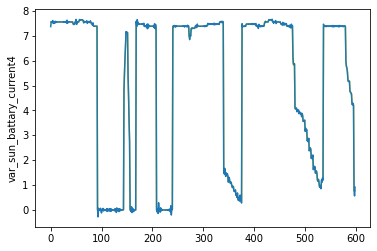

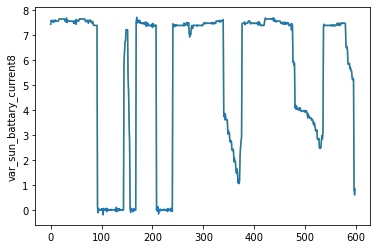

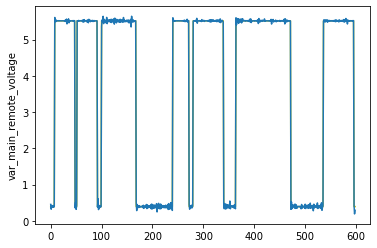

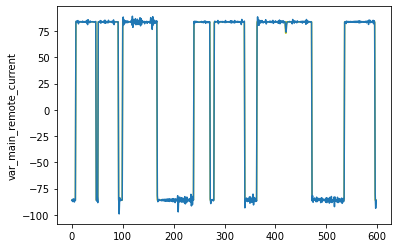

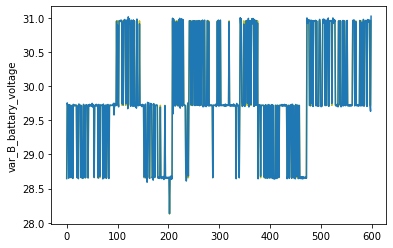

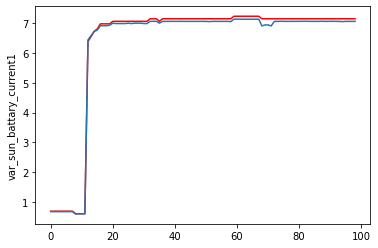

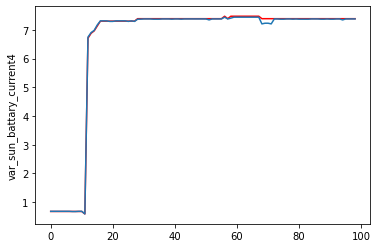

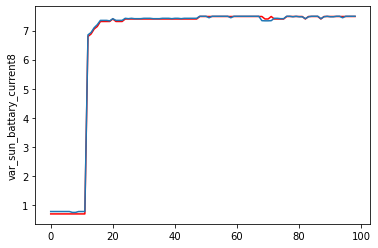

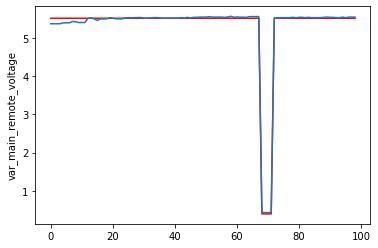

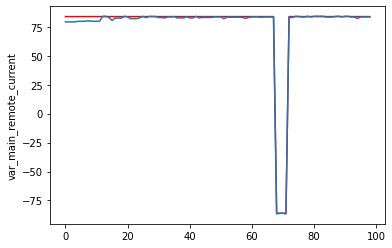

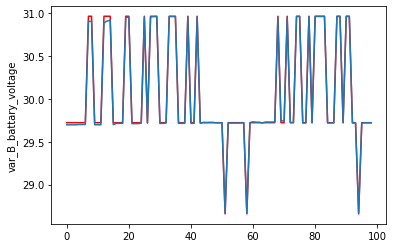

Training: [51/600] loss: 0.000
valid : [51/600] loss: 0.000
Training: [52/600] loss: 0.000
valid : [52/600] loss: 0.000
Training: [53/600] loss: 0.000
valid : [53/600] loss: 0.000
Training: [54/600] loss: 0.000
valid : [54/600] loss: 0.000
Training: [55/600] loss: 0.000
valid : [55/600] loss: 0.000
Training: [56/600] loss: 0.000
valid : [56/600] loss: 0.000
Training: [57/600] loss: 0.000
valid : [57/600] loss: 0.000
Training: [58/600] loss: 0.000
valid : [58/600] loss: 0.000
Training: [59/600] loss: 0.000
valid : [59/600] loss: 0.000
Training: [60/600] loss: 0.000
valid : [60/600] loss: 0.000
Training: [61/600] loss: 0.000
valid : [61/600] loss: 0.000
Training: [62/600] loss: 0.000
valid : [62/600] loss: 0.000
Training: [63/600] loss: 0.000
valid : [63/600] loss: 0.000
Training: [64/600] loss: 0.000
valid : [64/600] loss: 0.000
Training: [65/600] loss: 0.000
valid : [65/600] loss: 0.000
Training: [66/600] loss: 0.000
valid : [66/600] loss: 0.000
Training: [67/600] loss: 0.000
valid : [

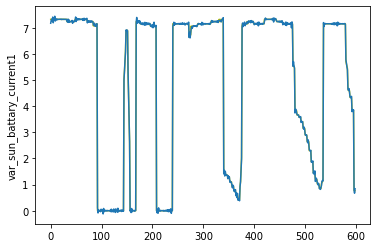

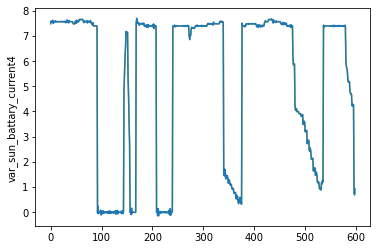

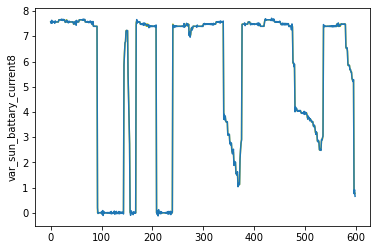

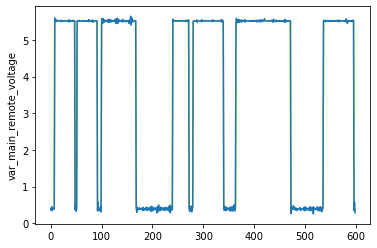

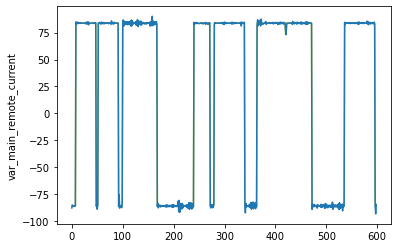

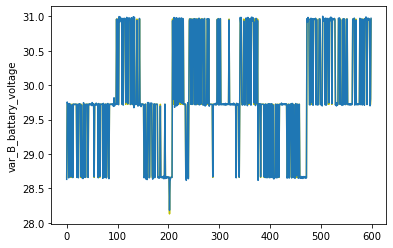

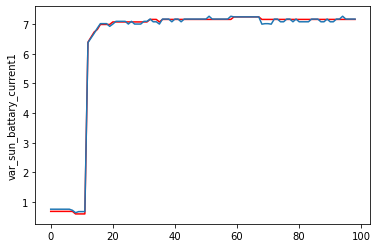

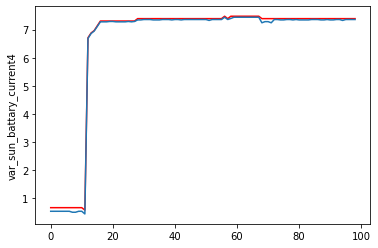

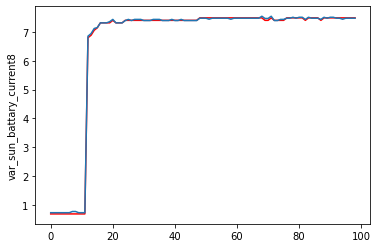

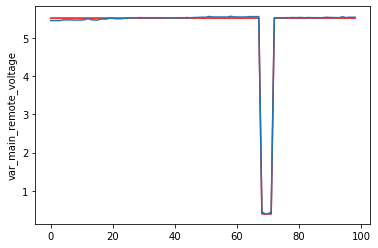

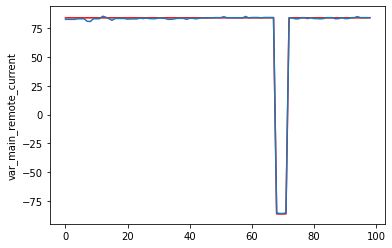

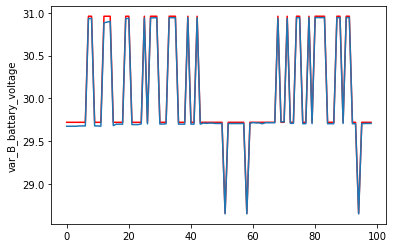

Training: [101/600] loss: 0.000
valid : [101/600] loss: 0.000
Training: [102/600] loss: 0.000
valid : [102/600] loss: 0.000
Training: [103/600] loss: 0.000
valid : [103/600] loss: 0.000
Training: [104/600] loss: 0.000
valid : [104/600] loss: 0.000
Training: [105/600] loss: 0.000
valid : [105/600] loss: 0.000
Training: [106/600] loss: 0.000
valid : [106/600] loss: 0.000
Training: [107/600] loss: 0.000
valid : [107/600] loss: 0.000
Training: [108/600] loss: 0.000
valid : [108/600] loss: 0.000
Training: [109/600] loss: 0.000
valid : [109/600] loss: 0.000
Training: [110/600] loss: 0.000
valid : [110/600] loss: 0.000
Training: [111/600] loss: 0.000
valid : [111/600] loss: 0.000
Training: [112/600] loss: 0.000
valid : [112/600] loss: 0.000
Training: [113/600] loss: 0.000
valid : [113/600] loss: 0.000
Training: [114/600] loss: 0.000
valid : [114/600] loss: 0.000
Training: [115/600] loss: 0.000
valid : [115/600] loss: 0.000
Training: [116/600] loss: 0.000
valid : [116/600] loss: 0.000
Training

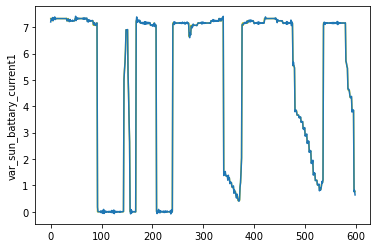

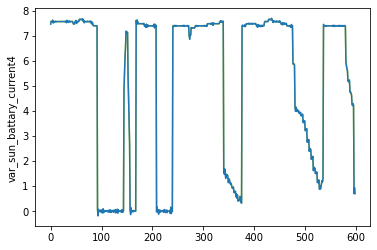

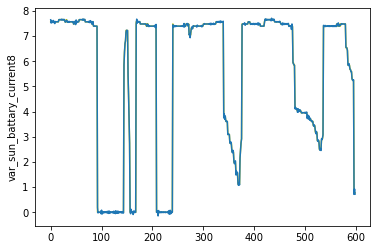

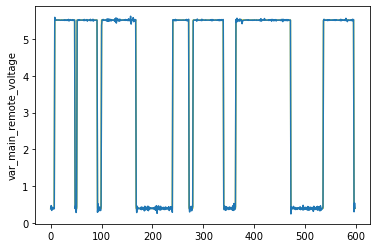

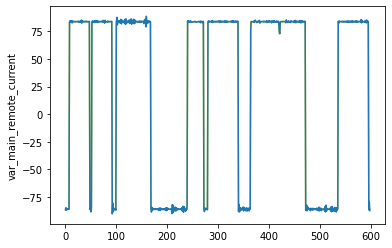

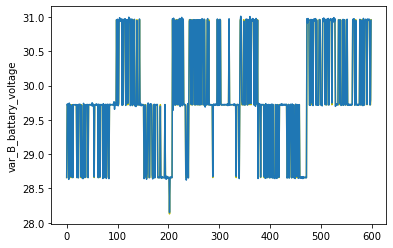

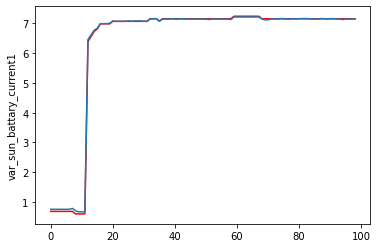

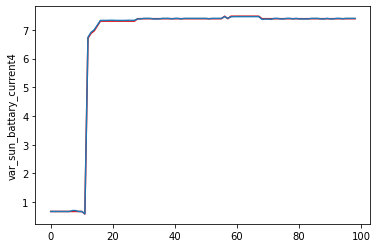

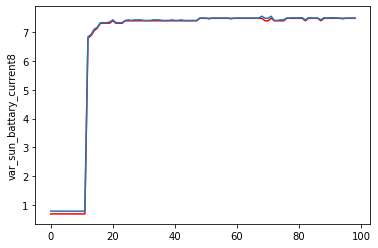

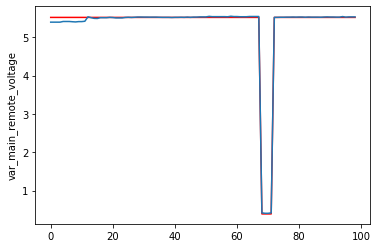

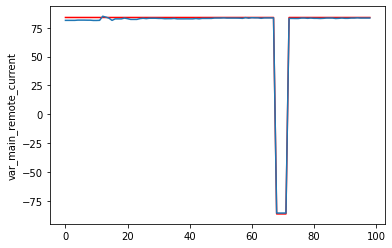

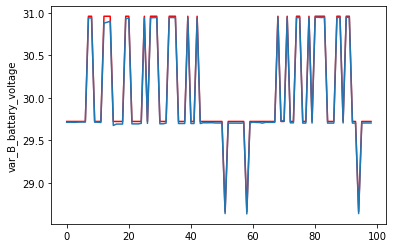

Training: [151/600] loss: 0.000
valid : [151/600] loss: 0.000
Training: [152/600] loss: 0.000
valid : [152/600] loss: 0.000
Training: [153/600] loss: 0.000
valid : [153/600] loss: 0.000
Training: [154/600] loss: 0.000
valid : [154/600] loss: 0.000
Training: [155/600] loss: 0.000
valid : [155/600] loss: 0.000
Training: [156/600] loss: 0.000
valid : [156/600] loss: 0.000
Training: [157/600] loss: 0.000
valid : [157/600] loss: 0.000
Training: [158/600] loss: 0.000
valid : [158/600] loss: 0.000
Training: [159/600] loss: 0.000
valid : [159/600] loss: 0.000
Training: [160/600] loss: 0.000
valid : [160/600] loss: 0.000
Training: [161/600] loss: 0.000
valid : [161/600] loss: 0.000
Training: [162/600] loss: 0.000
valid : [162/600] loss: 0.000
Training: [163/600] loss: 0.000
valid : [163/600] loss: 0.000
Training: [164/600] loss: 0.000
valid : [164/600] loss: 0.000
Training: [165/600] loss: 0.000
valid : [165/600] loss: 0.000
Training: [166/600] loss: 0.000
valid : [166/600] loss: 0.000
Training

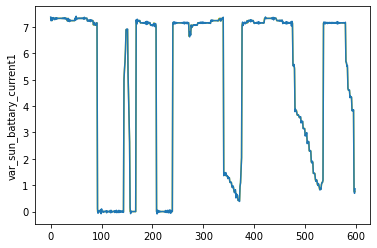

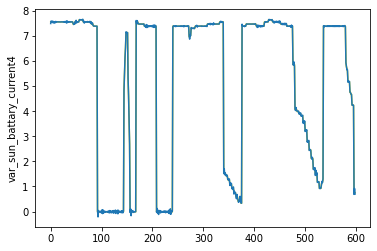

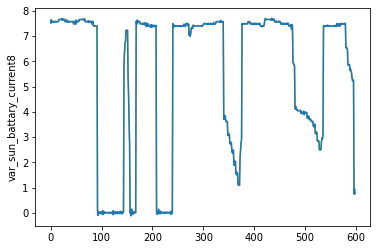

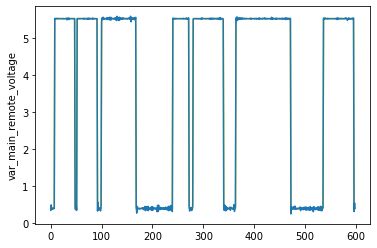

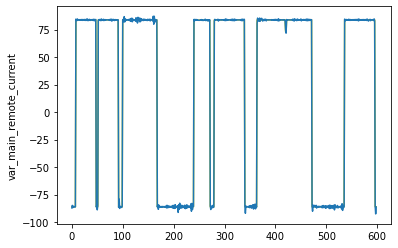

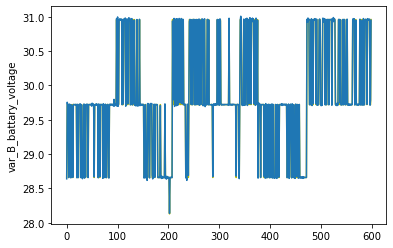

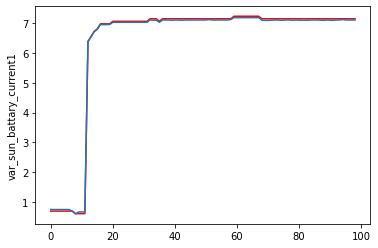

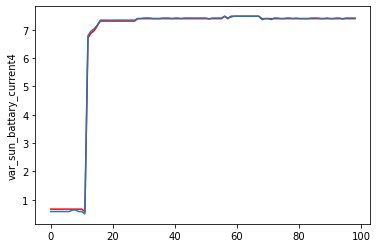

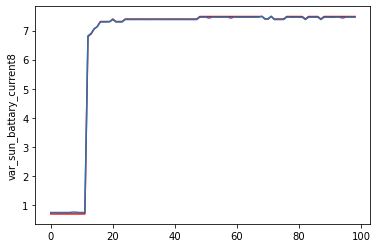

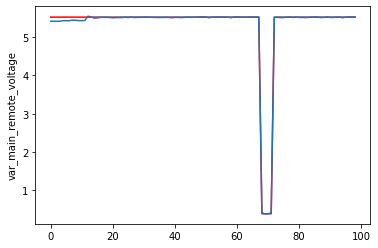

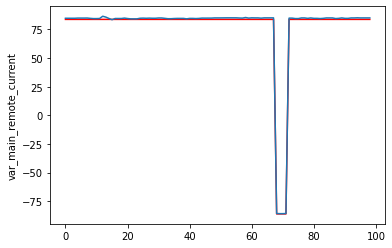

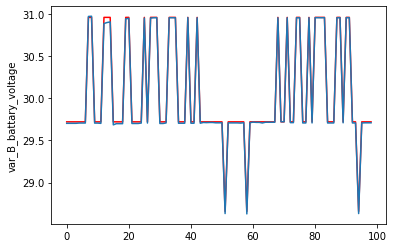

Training: [201/600] loss: 0.000
valid : [201/600] loss: 0.000
Training: [202/600] loss: 0.000
valid : [202/600] loss: 0.000
Training: [203/600] loss: 0.000
valid : [203/600] loss: 0.000
Training: [204/600] loss: 0.000
valid : [204/600] loss: 0.000
Training: [205/600] loss: 0.000
valid : [205/600] loss: 0.000
Training: [206/600] loss: 0.000
valid : [206/600] loss: 0.000
Training: [207/600] loss: 0.000
valid : [207/600] loss: 0.000
Training: [208/600] loss: 0.000
valid : [208/600] loss: 0.000
Training: [209/600] loss: 0.000
valid : [209/600] loss: 0.000
Training: [210/600] loss: 0.000
valid : [210/600] loss: 0.000
Training: [211/600] loss: 0.000
valid : [211/600] loss: 0.000
Training: [212/600] loss: 0.000
valid : [212/600] loss: 0.000
Training: [213/600] loss: 0.000
valid : [213/600] loss: 0.000
Training: [214/600] loss: 0.000
valid : [214/600] loss: 0.000
Training: [215/600] loss: 0.000
valid : [215/600] loss: 0.000
Training: [216/600] loss: 0.000
valid : [216/600] loss: 0.000
Training

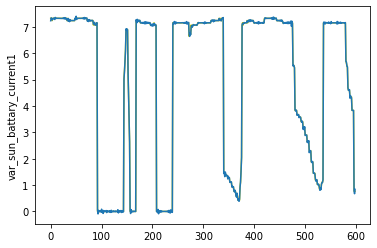

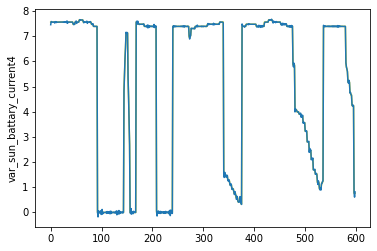

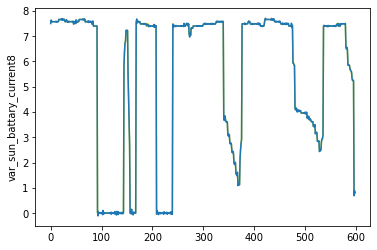

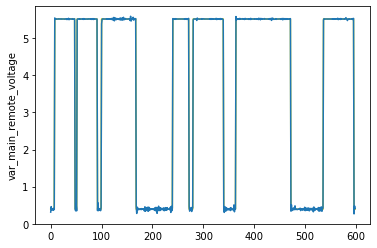

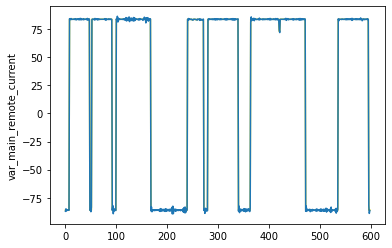

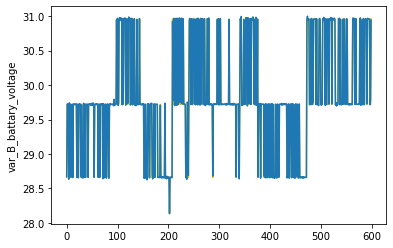

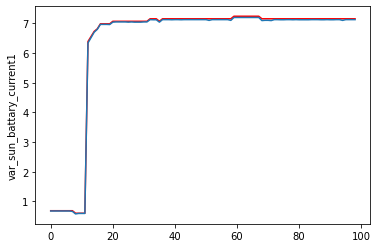

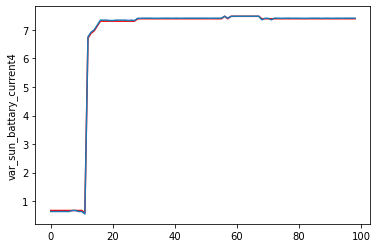

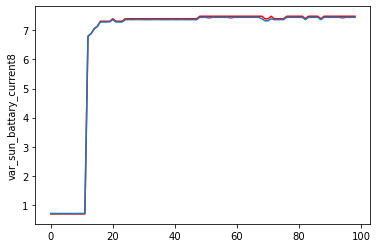

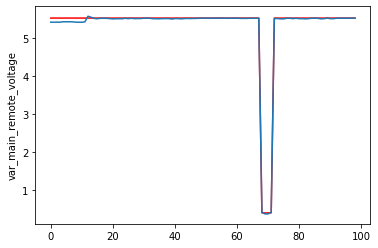

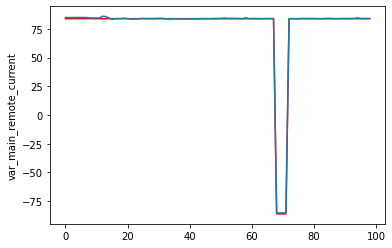

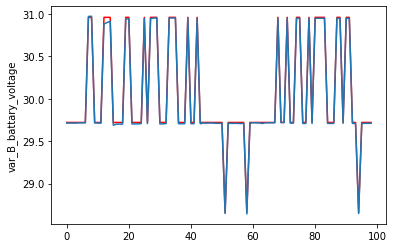

Training: [251/600] loss: 0.000
valid : [251/600] loss: 0.000
Training: [252/600] loss: 0.000
valid : [252/600] loss: 0.000
Training: [253/600] loss: 0.000
valid : [253/600] loss: 0.000
Training: [254/600] loss: 0.000
valid : [254/600] loss: 0.000
Training: [255/600] loss: 0.000
valid : [255/600] loss: 0.000
Training: [256/600] loss: 0.000
valid : [256/600] loss: 0.000
Training: [257/600] loss: 0.000
valid : [257/600] loss: 0.000
Training: [258/600] loss: 0.000
valid : [258/600] loss: 0.000
Training: [259/600] loss: 0.000
valid : [259/600] loss: 0.000
Training: [260/600] loss: 0.000
valid : [260/600] loss: 0.000
Training: [261/600] loss: 0.000
valid : [261/600] loss: 0.000
Training: [262/600] loss: 0.000
valid : [262/600] loss: 0.000
Training: [263/600] loss: 0.000
valid : [263/600] loss: 0.000
Training: [264/600] loss: 0.000
valid : [264/600] loss: 0.000
Training: [265/600] loss: 0.000
valid : [265/600] loss: 0.000
Training: [266/600] loss: 0.000
valid : [266/600] loss: 0.000
Training

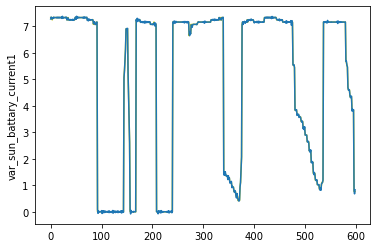

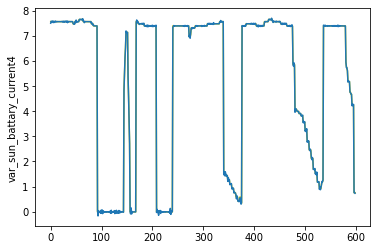

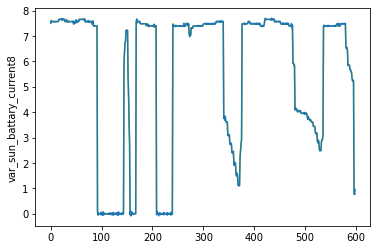

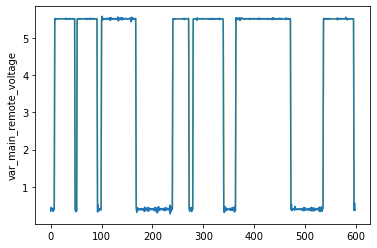

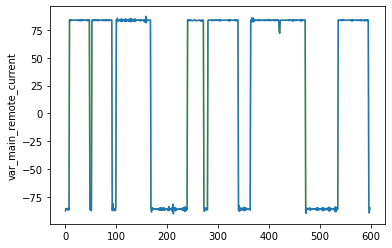

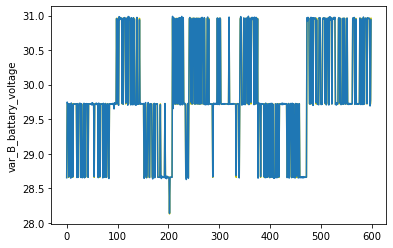

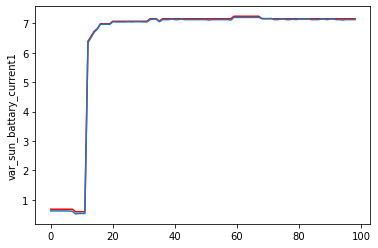

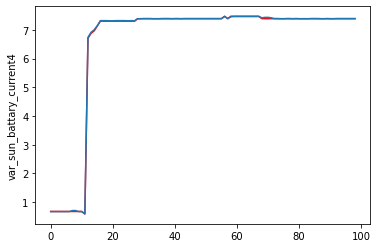

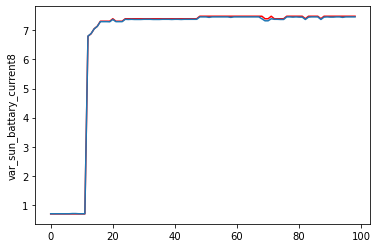

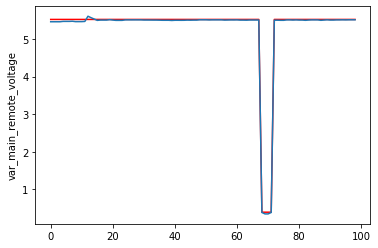

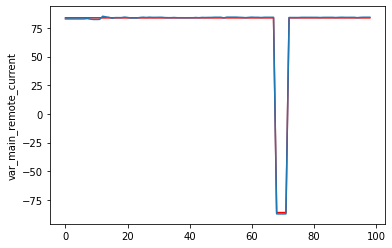

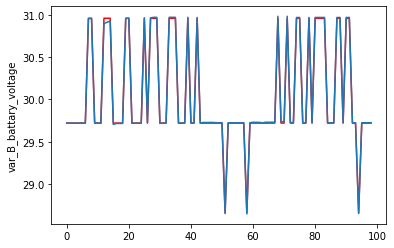

Training: [301/600] loss: 0.000
valid : [301/600] loss: 0.000
Training: [302/600] loss: 0.000
valid : [302/600] loss: 0.000
Training: [303/600] loss: 0.000
valid : [303/600] loss: 0.000
Training: [304/600] loss: 0.000
valid : [304/600] loss: 0.000
Training: [305/600] loss: 0.000
valid : [305/600] loss: 0.000
Training: [306/600] loss: 0.000
valid : [306/600] loss: 0.000
Training: [307/600] loss: 0.000
valid : [307/600] loss: 0.000
Training: [308/600] loss: 0.000
valid : [308/600] loss: 0.000
Training: [309/600] loss: 0.000
valid : [309/600] loss: 0.000
Training: [310/600] loss: 0.000
valid : [310/600] loss: 0.000
Training: [311/600] loss: 0.000
valid : [311/600] loss: 0.000
Training: [312/600] loss: 0.000
valid : [312/600] loss: 0.000
Training: [313/600] loss: 0.000
valid : [313/600] loss: 0.000
Training: [314/600] loss: 0.000
valid : [314/600] loss: 0.000
Training: [315/600] loss: 0.000
valid : [315/600] loss: 0.000
Training: [316/600] loss: 0.000
valid : [316/600] loss: 0.000
Training

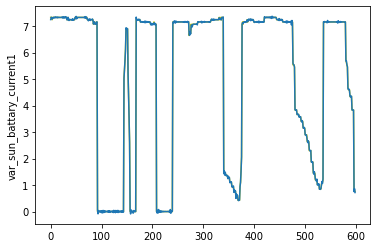

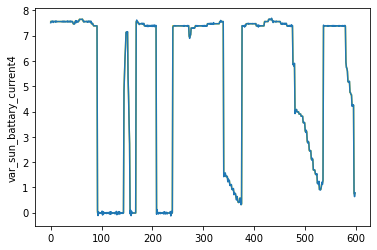

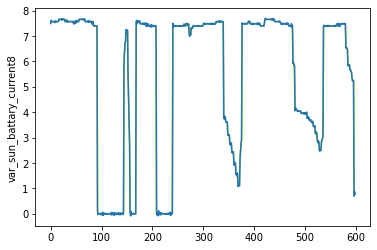

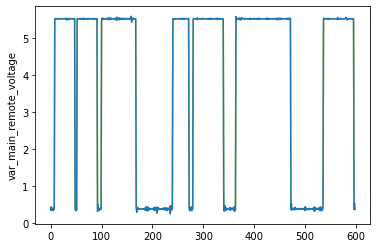

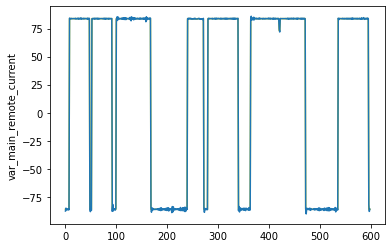

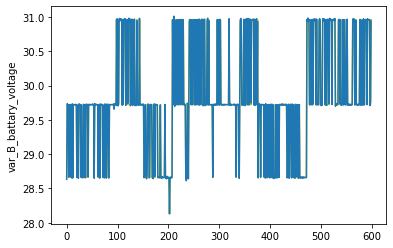

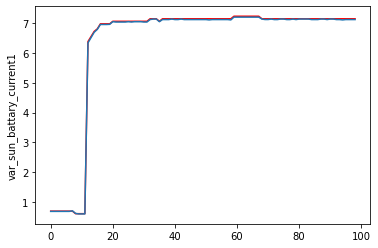

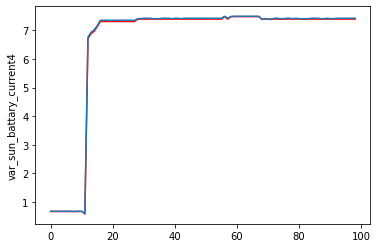

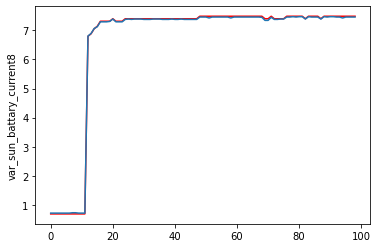

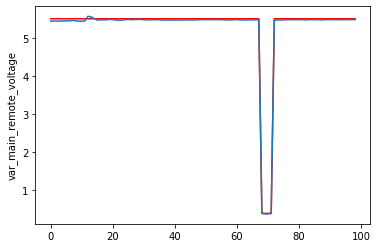

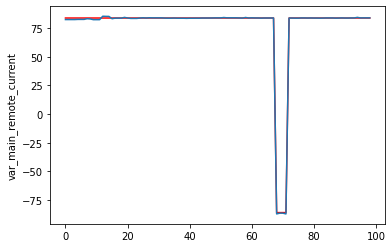

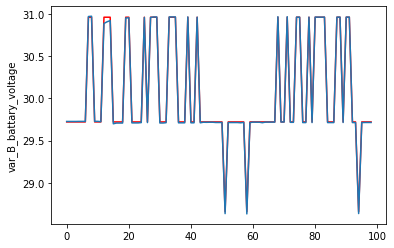

Training: [351/600] loss: 0.000
valid : [351/600] loss: 0.000
Training: [352/600] loss: 0.000
valid : [352/600] loss: 0.000
Training: [353/600] loss: 0.000
valid : [353/600] loss: 0.000
Training: [354/600] loss: 0.000
valid : [354/600] loss: 0.000
Training: [355/600] loss: 0.000
valid : [355/600] loss: 0.000
Training: [356/600] loss: 0.000
valid : [356/600] loss: 0.000
Training: [357/600] loss: 0.000
valid : [357/600] loss: 0.000
Training: [358/600] loss: 0.000
valid : [358/600] loss: 0.000
Training: [359/600] loss: 0.000
valid : [359/600] loss: 0.000
Training: [360/600] loss: 0.000
valid : [360/600] loss: 0.000
Training: [361/600] loss: 0.000
valid : [361/600] loss: 0.000
Training: [362/600] loss: 0.000
valid : [362/600] loss: 0.000
Training: [363/600] loss: 0.000
valid : [363/600] loss: 0.000
Training: [364/600] loss: 0.000
valid : [364/600] loss: 0.000
Training: [365/600] loss: 0.000
valid : [365/600] loss: 0.000
Training: [366/600] loss: 0.000
valid : [366/600] loss: 0.000
Training

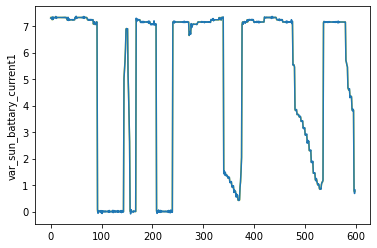

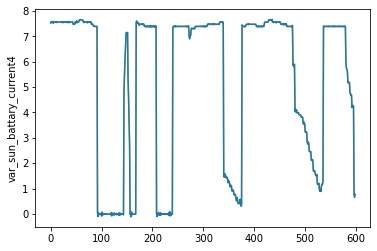

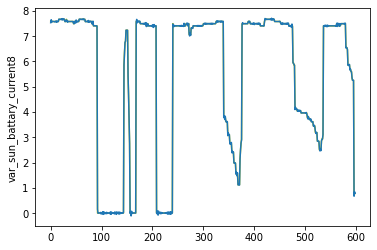

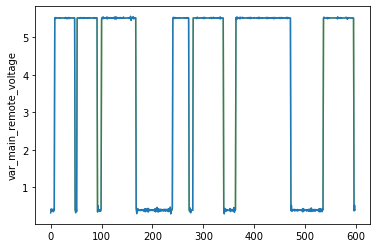

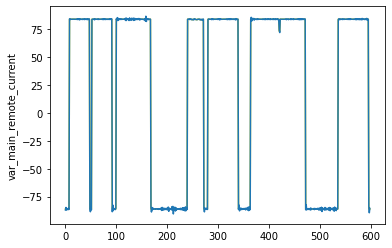

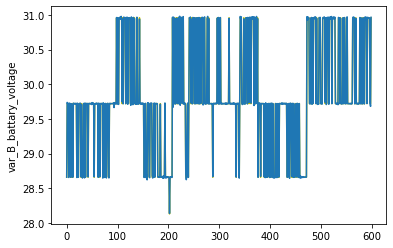

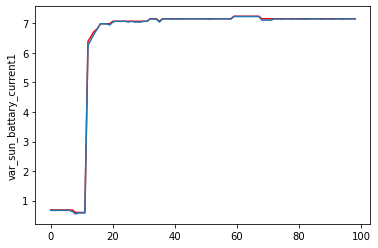

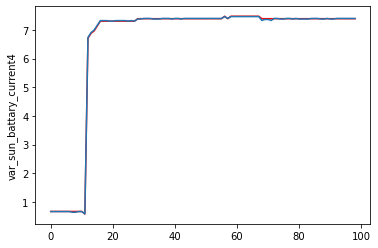

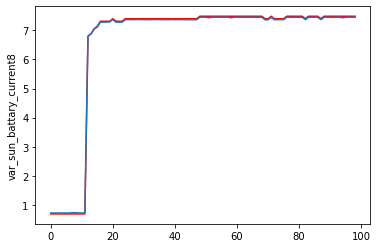

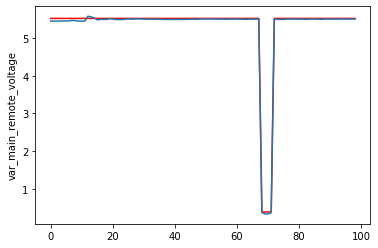

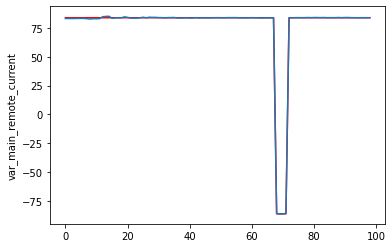

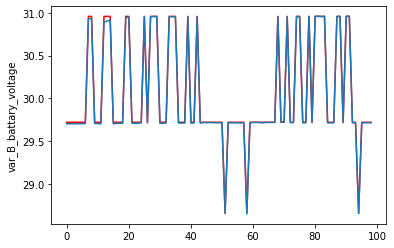

Training: [401/600] loss: 0.000
valid : [401/600] loss: 0.000
Training: [402/600] loss: 0.000
valid : [402/600] loss: 0.000
Training: [403/600] loss: 0.000
valid : [403/600] loss: 0.000
Training: [404/600] loss: 0.000
valid : [404/600] loss: 0.000
Training: [405/600] loss: 0.000
valid : [405/600] loss: 0.000
Training: [406/600] loss: 0.000
valid : [406/600] loss: 0.000
Training: [407/600] loss: 0.000
valid : [407/600] loss: 0.000
Training: [408/600] loss: 0.000
valid : [408/600] loss: 0.000
Training: [409/600] loss: 0.000
valid : [409/600] loss: 0.000
Training: [410/600] loss: 0.000
valid : [410/600] loss: 0.000
Training: [411/600] loss: 0.000
valid : [411/600] loss: 0.000
Training: [412/600] loss: 0.000
valid : [412/600] loss: 0.000
Training: [413/600] loss: 0.000
valid : [413/600] loss: 0.000
Training: [414/600] loss: 0.000
valid : [414/600] loss: 0.000
Training: [415/600] loss: 0.000
valid : [415/600] loss: 0.000
Training: [416/600] loss: 0.000
valid : [416/600] loss: 0.000
Training

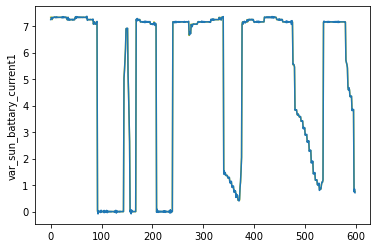

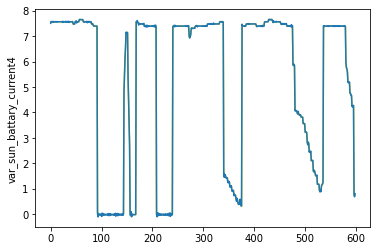

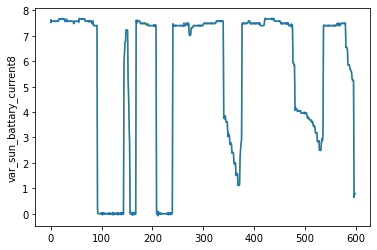

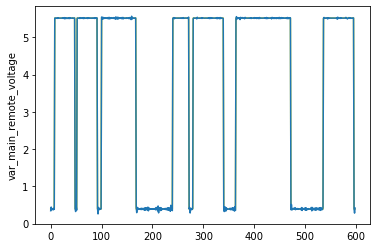

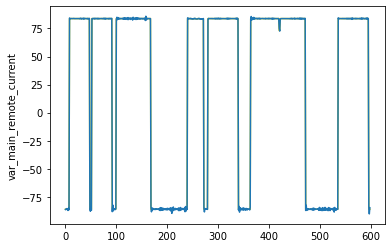

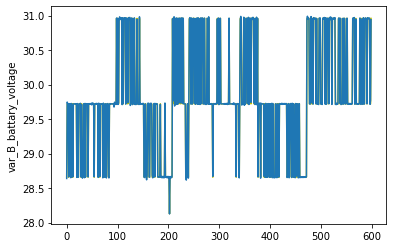

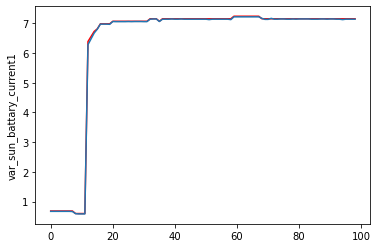

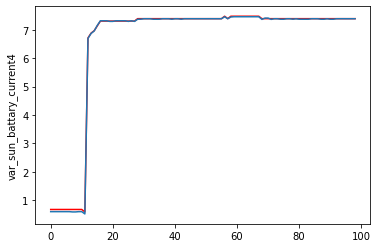

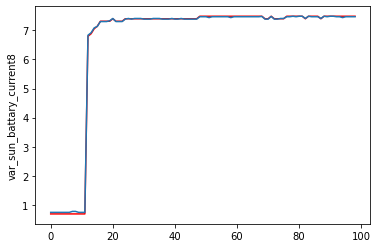

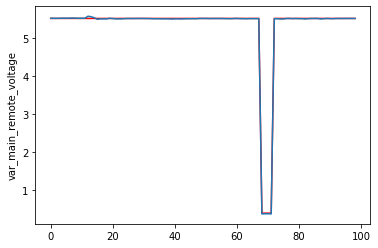

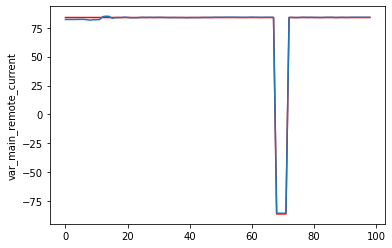

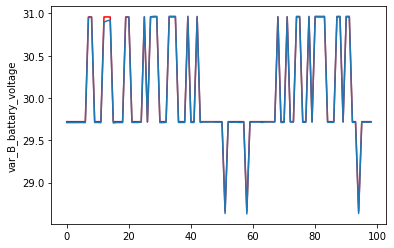

Training: [451/600] loss: 0.000
valid : [451/600] loss: 0.000
Training: [452/600] loss: 0.000
valid : [452/600] loss: 0.000
Training: [453/600] loss: 0.000
valid : [453/600] loss: 0.000
Training: [454/600] loss: 0.000
valid : [454/600] loss: 0.000
Training: [455/600] loss: 0.000
valid : [455/600] loss: 0.000
Training: [456/600] loss: 0.000
valid : [456/600] loss: 0.000
Training: [457/600] loss: 0.000
valid : [457/600] loss: 0.000
Training: [458/600] loss: 0.000
valid : [458/600] loss: 0.000
Training: [459/600] loss: 0.000
valid : [459/600] loss: 0.000
Training: [460/600] loss: 0.000
valid : [460/600] loss: 0.000
Training: [461/600] loss: 0.000
valid : [461/600] loss: 0.000
Training: [462/600] loss: 0.000
valid : [462/600] loss: 0.000
Training: [463/600] loss: 0.000
valid : [463/600] loss: 0.000
Training: [464/600] loss: 0.000
valid : [464/600] loss: 0.000
Training: [465/600] loss: 0.000
valid : [465/600] loss: 0.000
Training: [466/600] loss: 0.000
valid : [466/600] loss: 0.000
Training

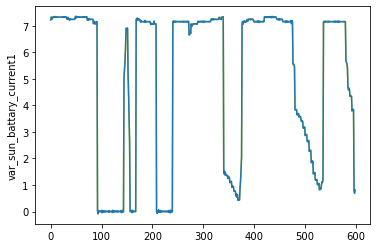

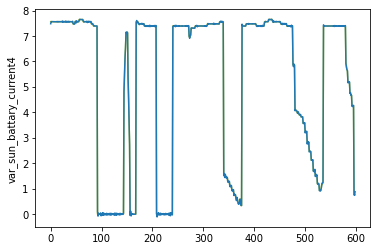

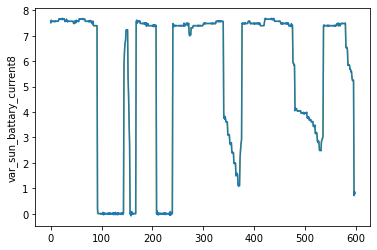

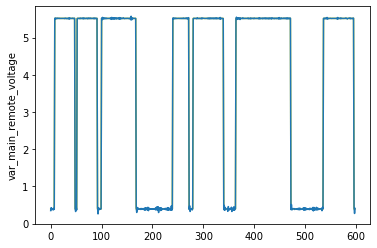

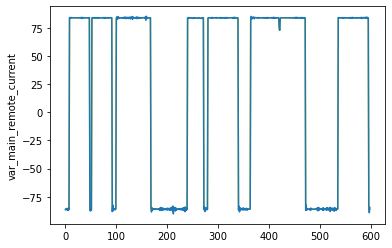

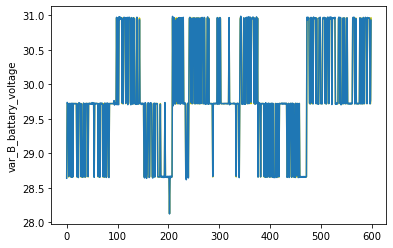

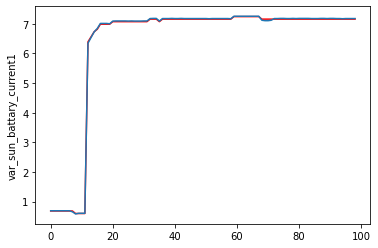

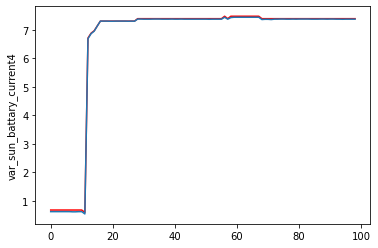

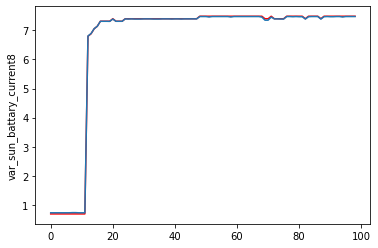

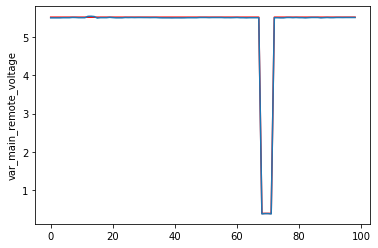

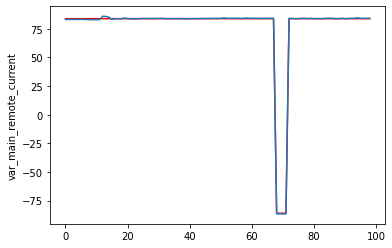

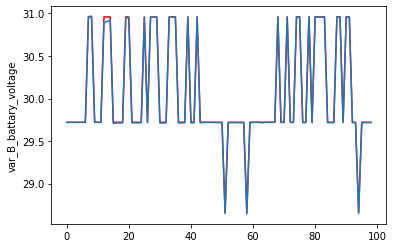

Training: [501/600] loss: 0.000
valid : [501/600] loss: 0.000
Training: [502/600] loss: 0.000
valid : [502/600] loss: 0.000
Training: [503/600] loss: 0.000
valid : [503/600] loss: 0.000
Training: [504/600] loss: 0.000
valid : [504/600] loss: 0.000
Training: [505/600] loss: 0.000
valid : [505/600] loss: 0.000
Training: [506/600] loss: 0.000
valid : [506/600] loss: 0.000
Training: [507/600] loss: 0.000
valid : [507/600] loss: 0.000
Training: [508/600] loss: 0.000
valid : [508/600] loss: 0.000
Training: [509/600] loss: 0.000
valid : [509/600] loss: 0.000
Training: [510/600] loss: 0.000
valid : [510/600] loss: 0.000
Training: [511/600] loss: 0.000
valid : [511/600] loss: 0.000
Training: [512/600] loss: 0.000
valid : [512/600] loss: 0.000
Training: [513/600] loss: 0.000
valid : [513/600] loss: 0.000
Training: [514/600] loss: 0.000
valid : [514/600] loss: 0.000
Training: [515/600] loss: 0.000
valid : [515/600] loss: 0.000
Training: [516/600] loss: 0.000
valid : [516/600] loss: 0.000
Training

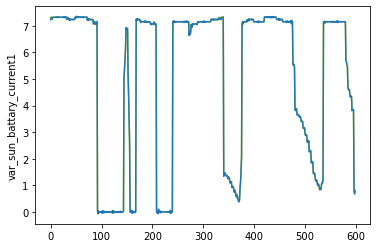

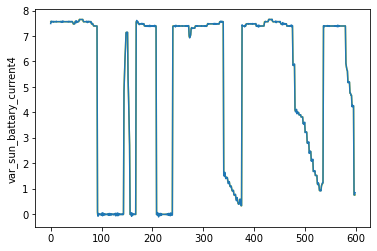

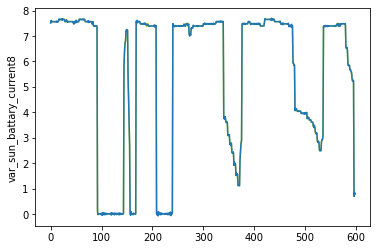

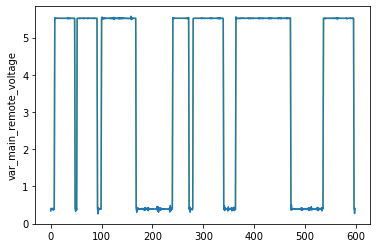

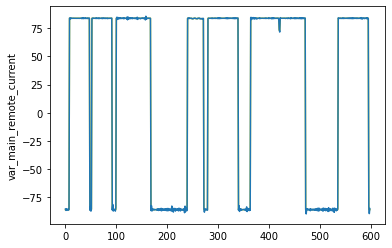

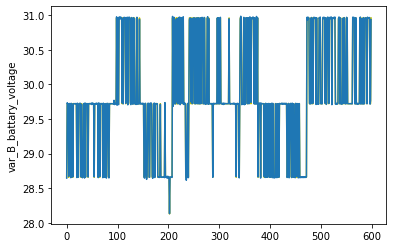

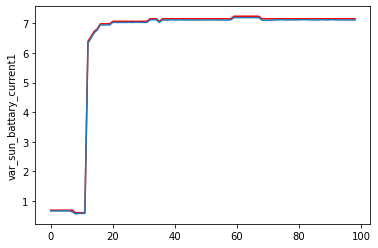

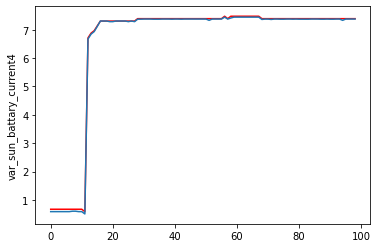

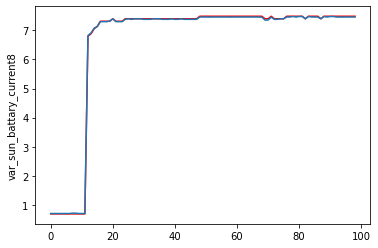

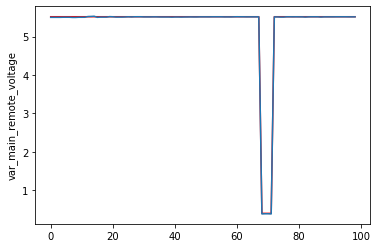

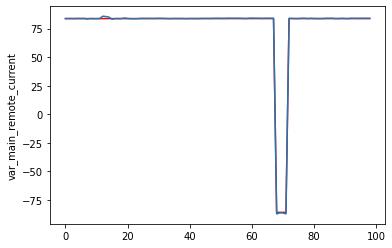

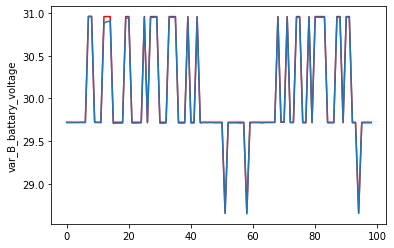

Training: [551/600] loss: 0.000
valid : [551/600] loss: 0.000
Training: [552/600] loss: 0.000
valid : [552/600] loss: 0.000
Training: [553/600] loss: 0.000
valid : [553/600] loss: 0.000
Training: [554/600] loss: 0.000
valid : [554/600] loss: 0.000
Training: [555/600] loss: 0.000
valid : [555/600] loss: 0.000
Training: [556/600] loss: 0.000
valid : [556/600] loss: 0.000
Training: [557/600] loss: 0.000
valid : [557/600] loss: 0.000
Training: [558/600] loss: 0.000
valid : [558/600] loss: 0.000
Training: [559/600] loss: 0.000
valid : [559/600] loss: 0.000
Training: [560/600] loss: 0.000
valid : [560/600] loss: 0.000
Training: [561/600] loss: 0.000
valid : [561/600] loss: 0.000
Training: [562/600] loss: 0.000
valid : [562/600] loss: 0.000
Training: [563/600] loss: 0.000
valid : [563/600] loss: 0.000
Training: [564/600] loss: 0.000
valid : [564/600] loss: 0.000
Training: [565/600] loss: 0.000
valid : [565/600] loss: 0.000
Training: [566/600] loss: 0.000
valid : [566/600] loss: 0.000
Training

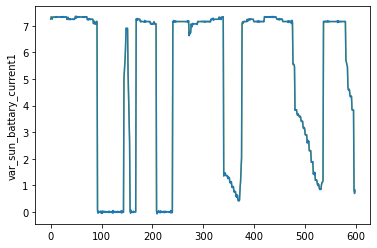

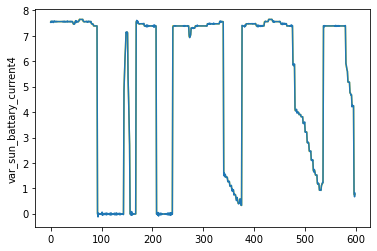

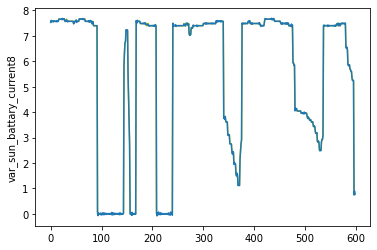

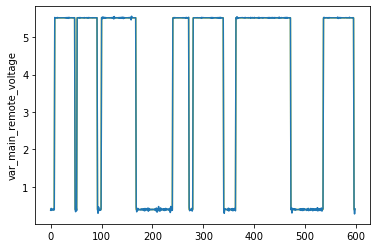

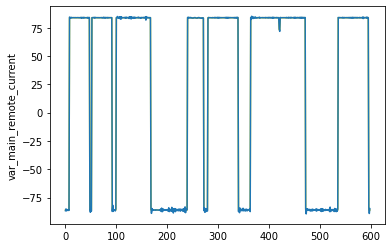

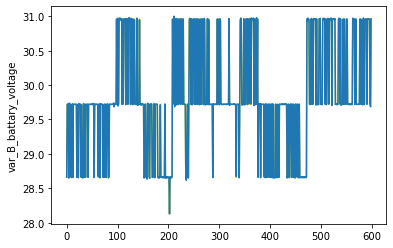

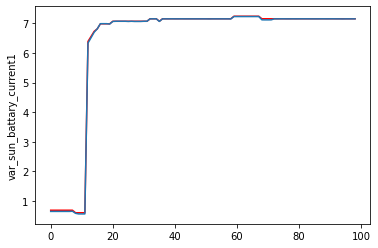

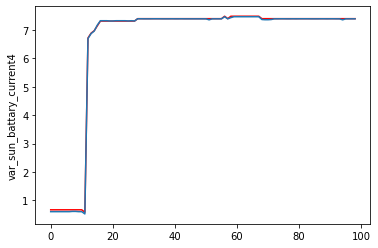

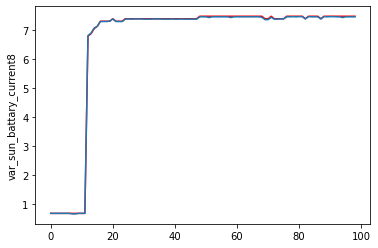

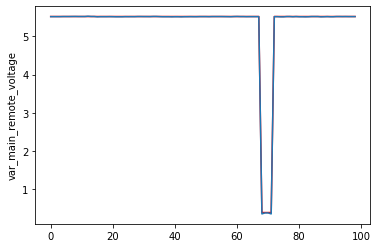

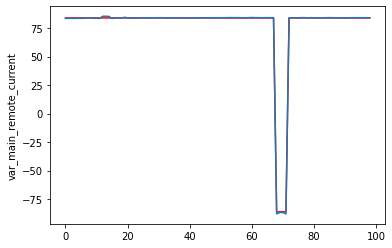

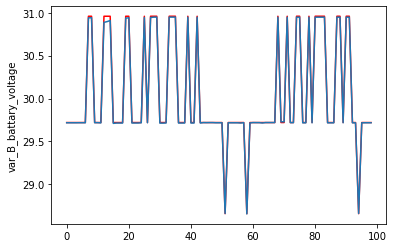

test : [600/600] loss: 0.000
save success
Optimization Finished!
執行時間：4905.294127 秒


In [19]:
training_epochs = 600
keep_prob = 0.3

########## train set ##########
batch_size_train = multiply  # multiply
display_step = 1  # 顯示loss
display_step_draw = 50  # 50        # 畫圖

########## valid set ##########
valid_step = 1

batch_size_valid = multiply
display_step_draw_valid = 50  # 50   # 畫圖

########## test set ##########
batch_size_test = multiply

# 存儲loss
train_hist = {}
train_hist['Error_train'] = []
valid_hist = {}
valid_hist['Error_valid'] = []

with graph_offline.as_default():
    saver = tf.train.Saver()

    gpu_options = tf.GPUOptions(allow_growth=True)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options), graph=graph_offline) as sess:
        sess.run(tf.global_variables_initializer())

        print('Optimization start!')
        start = time.time()

        for epoch in range(training_epochs):
            '''#############        訓練集 train set      ####################### '''
            # Loss
            error_train = []

            # draw
            output_real = []
            output_pred = []

            is_first = True
            for i in range(len(data_train_window) // batch_size_train):
                x_train = data_train_window[i * batch_size_train: (i + 1) * batch_size_train]

                # 優化、紀錄loss
                _, cost_train, fake_output, real_output = sess.run([optimizer, cost, pred, label],
                                                                   feed_dict={X: x_train,
                                                                              keep_prob_feed: keep_prob,
                                                                              batch_size_feed: batch_size_train,
                                                                              global_step: epoch,
                                                                              Feature_Index_1: feature_index_1,
                                                                              Label_Index_1: label_index_1,
                                                                              Feature_Index_2: feature_index_2,
                                                                              Label_Index_2: label_index_2,
                                                                              Feature_Index_3: feature_index_3,
                                                                              Label_Index_3: label_index_3,                                                                              
                                                                              Feature_Index_4: feature_index_4,
                                                                              Label_Index_4: label_index_4,                                                                              
                                                                              Feature_Index_5: feature_index_5,
                                                                              Label_Index_5: label_index_5,                                                                              
                                                                              Feature_Index_6: feature_index_6,
                                                                              Label_Index_6: label_index_6, 
                                                                              Feature_Index_normal: feature_index_normal,
                                                                              })
                # Loss
                error_train.append(cost_train)

                # draw
                output_real.append(real_output)
                output_pred.append(fake_output)

            train_hist['Error_train'].append(np.mean(error_train))

            print('Training: [%d/%d] loss: %.3f' % ((epoch + 1), training_epochs, np.mean(error_train)))

            '''#############        驗證集 valid set      ####################### '''
            if (epoch + 1) % valid_step == 0:
                # Loss
                error_valid = []

                # draw
                output_real_valid = []
                output_pred_valid = []

                for i in range(len(data_valid_window) // batch_size_valid):
                    x_valid = data_valid_window[i * batch_size_valid: (i + 1) * batch_size_valid]

                    # 優化、紀錄loss
                    cost_valid, fake_output, real_output = sess.run([cost, pred, label],
                                                                    feed_dict={X: x_valid,
                                                                               keep_prob_feed: 1,
                                                                               batch_size_feed: batch_size_valid,
                                                                               global_step: epoch,
                                                                              Feature_Index_1: feature_index_1,
                                                                              Label_Index_1: label_index_1,
                                                                              Feature_Index_2: feature_index_2,
                                                                              Label_Index_2: label_index_2,
                                                                              Feature_Index_3: feature_index_3,
                                                                              Label_Index_3: label_index_3,                                                                              
                                                                              Feature_Index_4: feature_index_4,
                                                                              Label_Index_4: label_index_4,                                                                              
                                                                              Feature_Index_5: feature_index_5,
                                                                              Label_Index_5: label_index_5,                                                                              
                                                                              Feature_Index_6: feature_index_6,
                                                                              Label_Index_6: label_index_6,   
                                                                              Feature_Index_normal: feature_index_normal,
                                                                               })
                    # Loss
                    error_valid.append(cost_valid)

                    # draw
                    output_real_valid.append(real_output)
                    output_pred_valid.append(fake_output)

                valid_hist['Error_valid'].append(np.mean(error_valid))

                print('valid : [%d/%d] loss: %.3f' % ((epoch + 1), training_epochs, np.mean(error_valid)))

            '''#############       訓練集與驗證集 畫圖區       #######################'''
            if (epoch + 1) % display_step_draw == 0:  # 訓練集
                draw_during_train(output_real, output_pred, mean_vital, std_vital)
            
            if (epoch + 1) % display_step_draw_valid == 0:  # 驗證集
                draw_during_valid(output_real_valid, output_pred_valid, mean_vital, std_vital)

        '''#############        測試集 test set      ####################### '''
        # Loss
        error_test = []

        # draw
        output_real_test = []
        output_pred_test = []

        for i in range(len(data_test_window) // batch_size_test):
            x_test = data_test_window[i * batch_size_test: (i + 1) * batch_size_test]

            # 優化、紀錄loss
            cost_test, fake_output, real_output = sess.run([cost, pred, label],
                                                           feed_dict={X: x_test,
                                                                      keep_prob_feed: 1,
                                                                      batch_size_feed: batch_size_test,
                                                                      global_step: epoch,
                                                                      Feature_Index_1: feature_index_1,
                                                                      Label_Index_1: label_index_1,
                                                                      Feature_Index_2: feature_index_2,
                                                                      Label_Index_2: label_index_2,
                                                                      Feature_Index_3: feature_index_3,
                                                                      Label_Index_3: label_index_3,                                                                              
                                                                      Feature_Index_4: feature_index_4,
                                                                      Label_Index_4: label_index_4,                                                                              
                                                                      Feature_Index_5: feature_index_5,
                                                                      Label_Index_5: label_index_5,                                                                              
                                                                      Feature_Index_6: feature_index_6,
                                                                      Label_Index_6: label_index_6,   
                                                                      Feature_Index_normal: feature_index_normal,
                                                                      })
            # Loss
            error_test.append(cost_test)

            # draw
            output_real_test.append(x_test)
            output_pred_test.append(fake_output)

        print('test : [%d/%d] loss: %.3f' % ((epoch + 1), training_epochs, np.mean(error_test)))
        # draw_during_test(output_real_test, output_pred_test, mean_vital, std_vital)  # 測試集畫圖

        ##############################################  END ##############################################
        saver.save(sess, saver_path)
        print('save success')
        sess.close()

print("Optimization Finished!")
end = time.time()
print("執行時間：%f 秒" % (end - start))

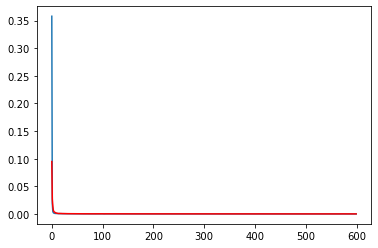

<Figure size 432x288 with 0 Axes>

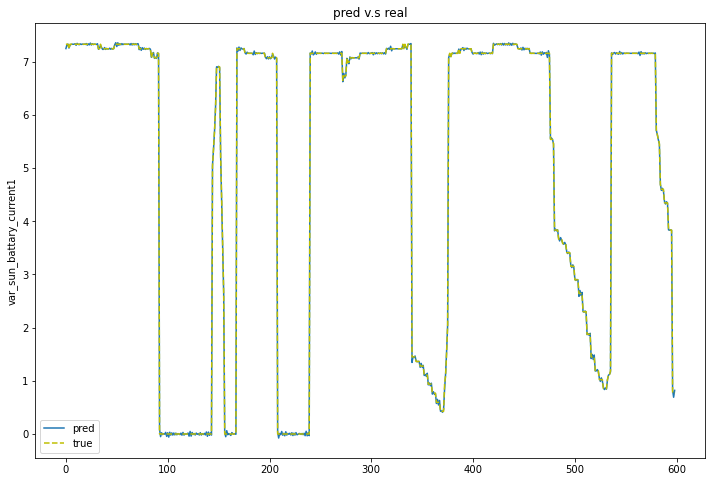

<Figure size 432x288 with 0 Axes>

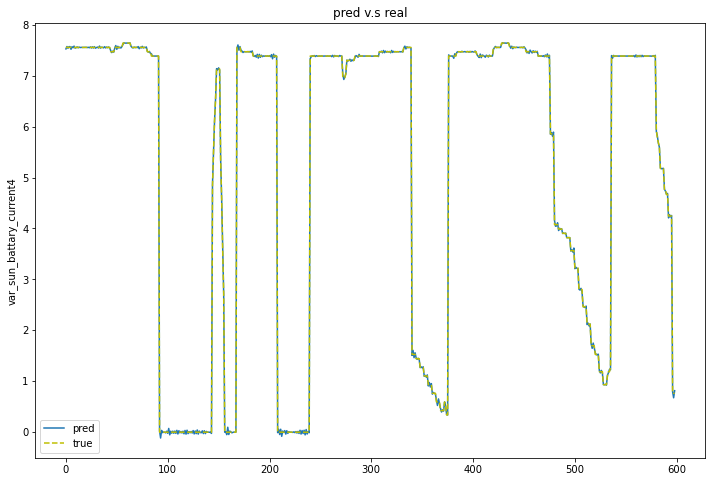

<Figure size 432x288 with 0 Axes>

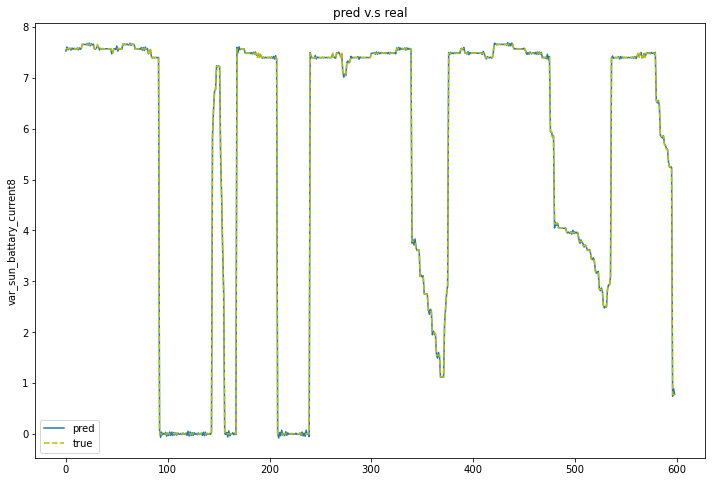

<Figure size 432x288 with 0 Axes>

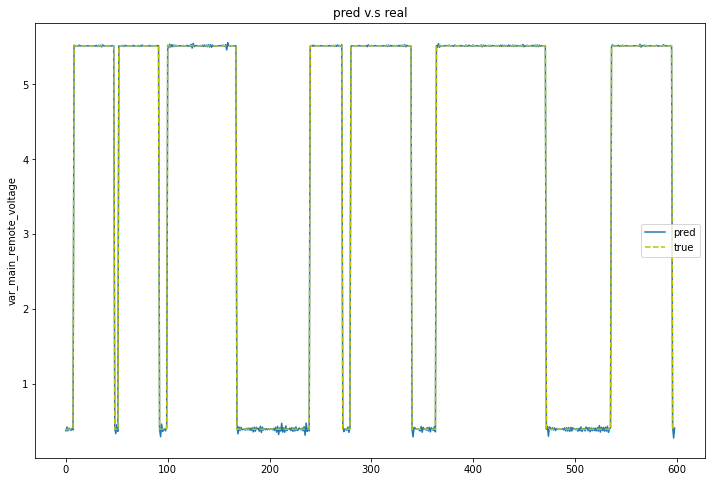

<Figure size 432x288 with 0 Axes>

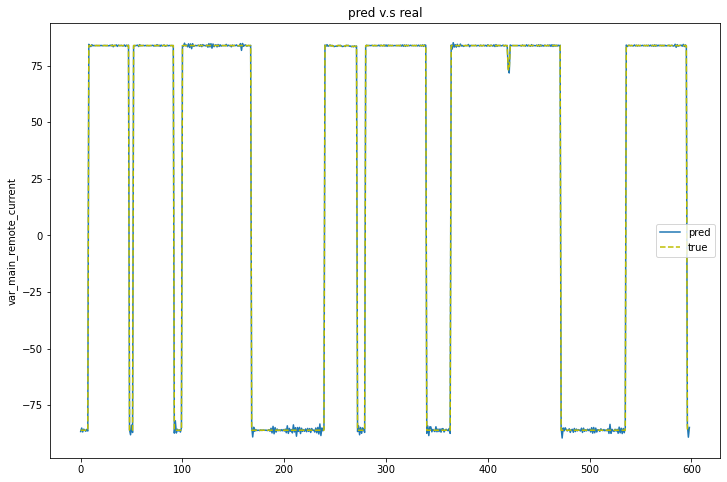

<Figure size 432x288 with 0 Axes>

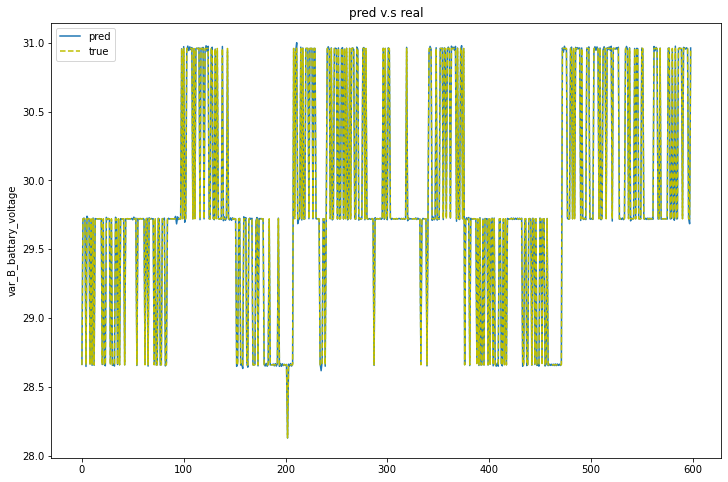

<Figure size 432x288 with 0 Axes>

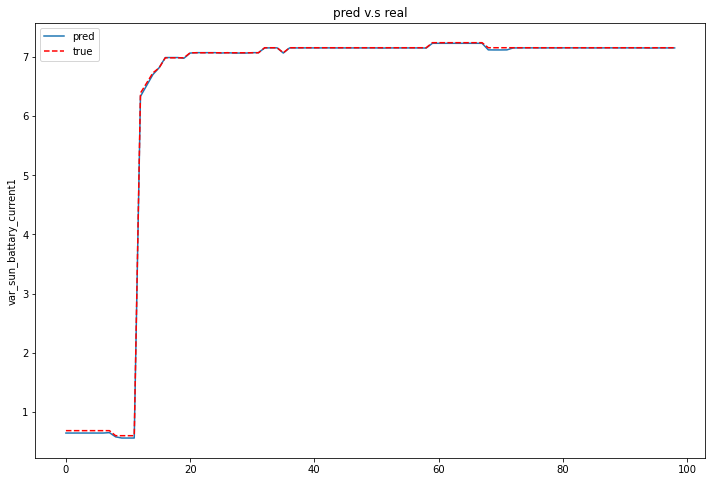

<Figure size 432x288 with 0 Axes>

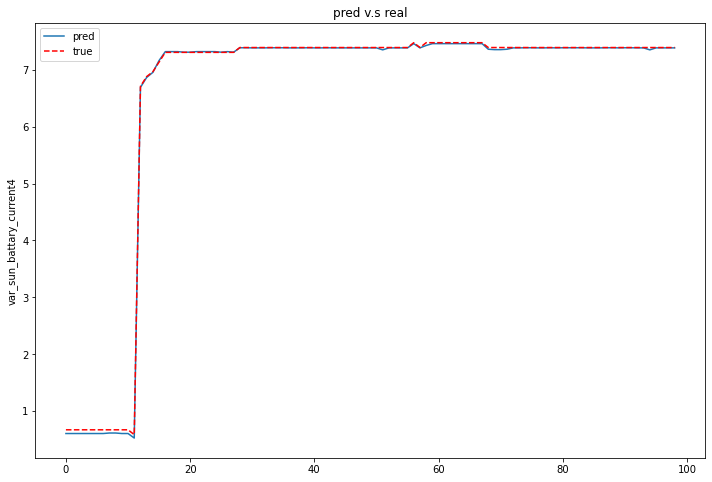

<Figure size 432x288 with 0 Axes>

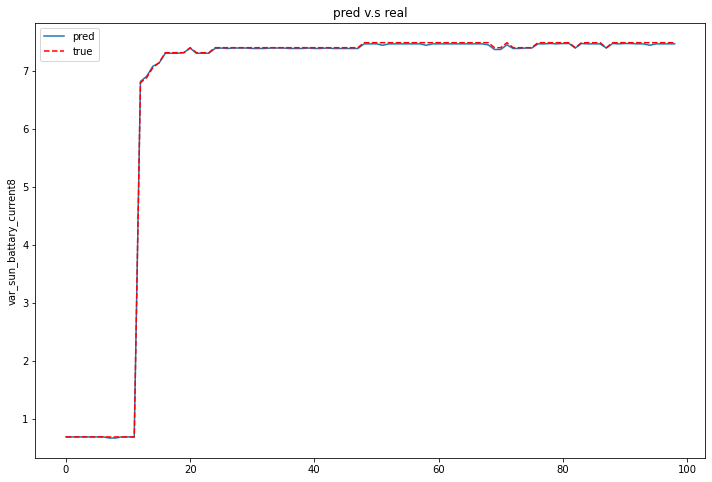

<Figure size 432x288 with 0 Axes>

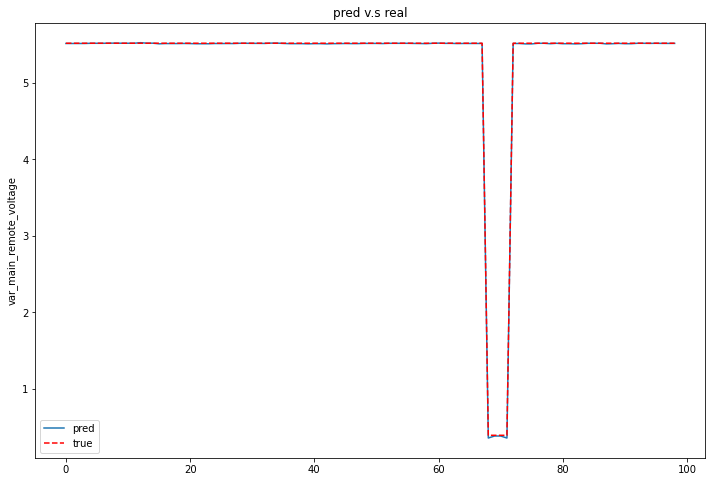

<Figure size 432x288 with 0 Axes>

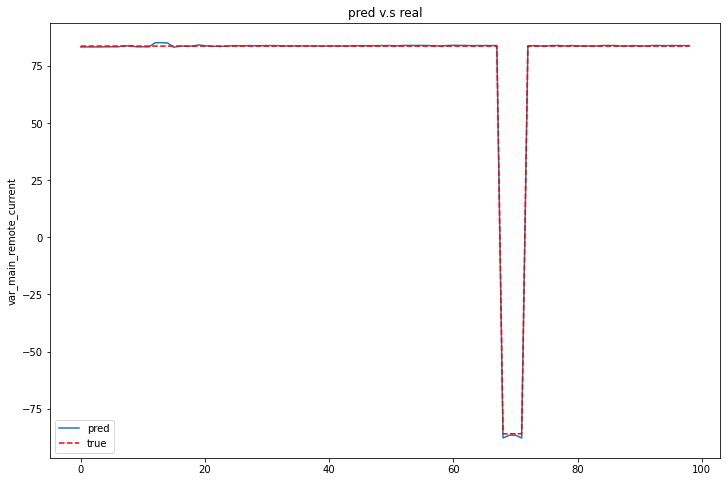

<Figure size 432x288 with 0 Axes>

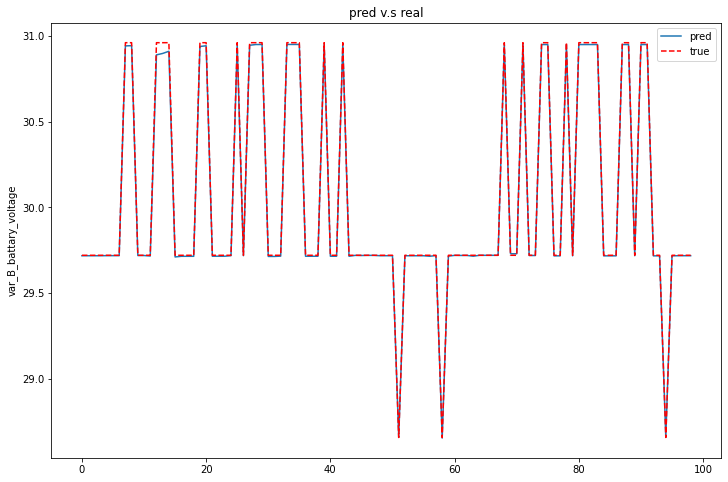

<Figure size 432x288 with 0 Axes>

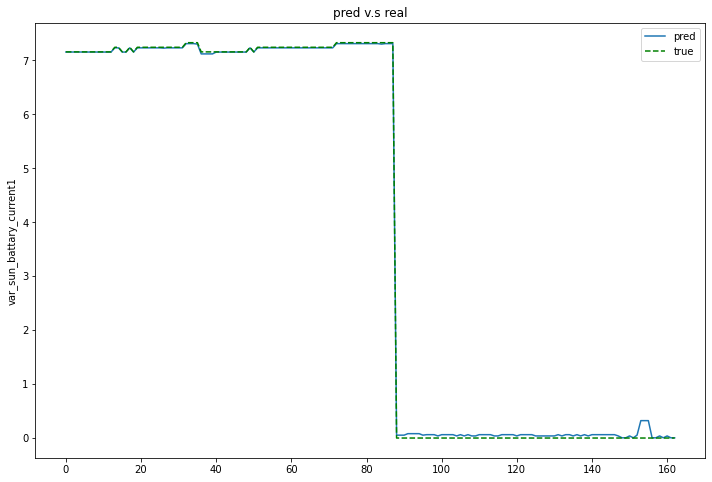

<Figure size 432x288 with 0 Axes>

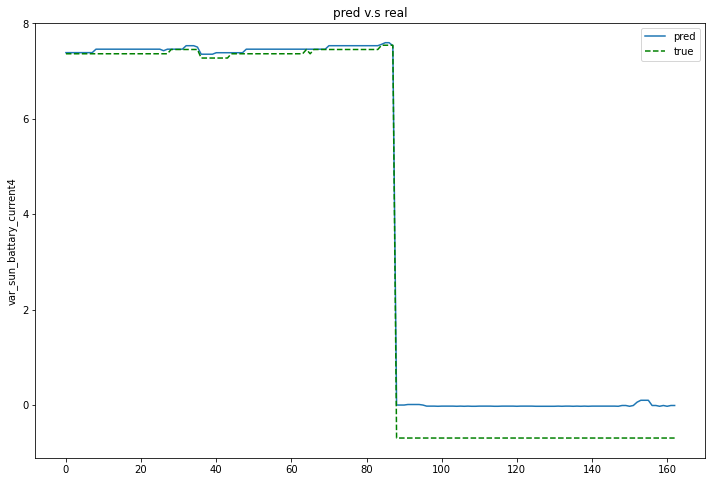

<Figure size 432x288 with 0 Axes>

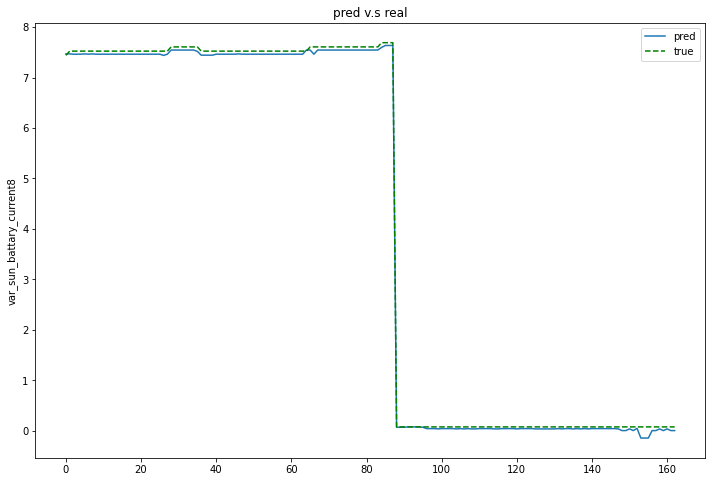

<Figure size 432x288 with 0 Axes>

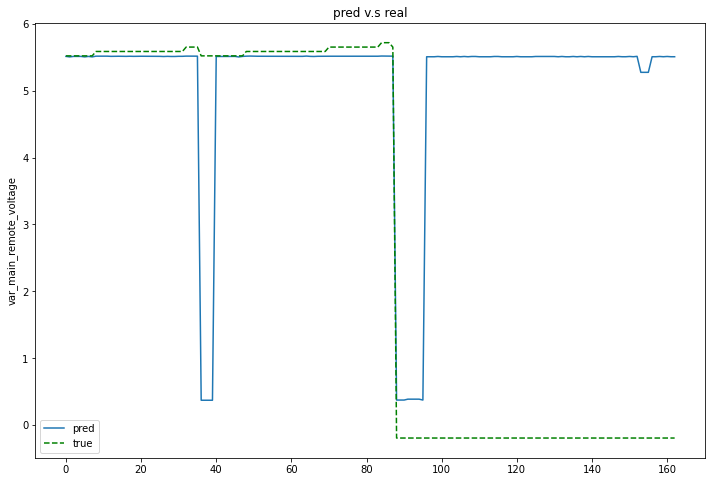

<Figure size 432x288 with 0 Axes>

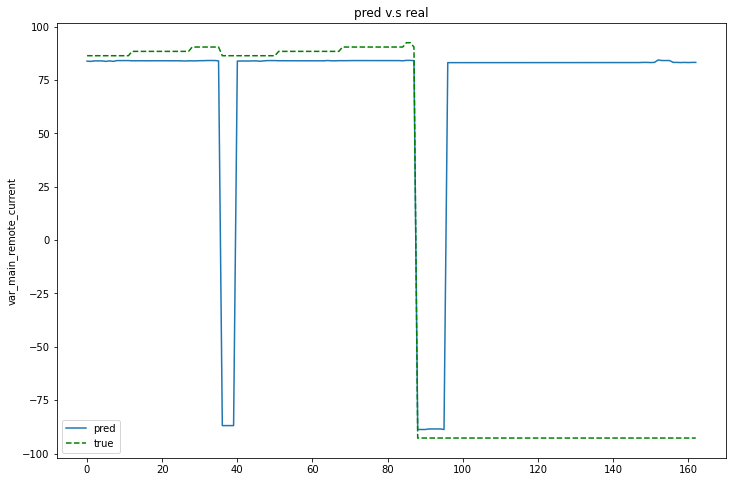

<Figure size 432x288 with 0 Axes>

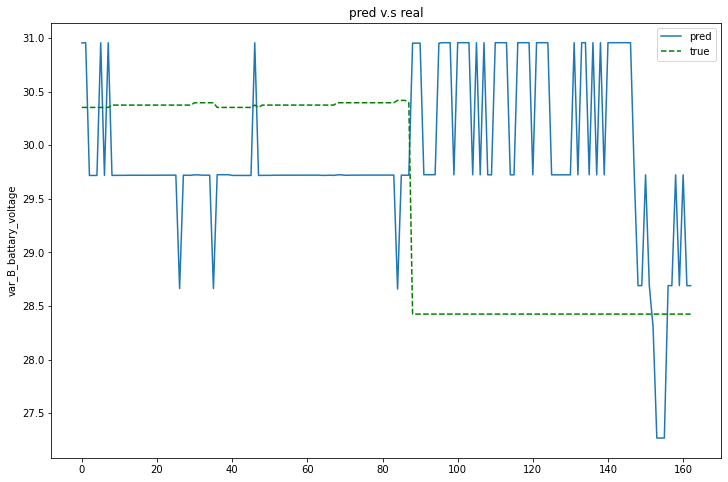

In [20]:
'''LOSS Curve'''
plt.plot(train_hist['Error_train'])
plt.plot(valid_hist['Error_valid'],'r')

''' 訓練集畫圖 '''
draw_final_train(output_real, output_pred, mean_vital, std_vital)
''' 驗證集畫圖 '''
draw_final_valid(output_real_valid, output_pred_valid, mean_vital, std_vital)
''' 測試集畫圖 '''
draw_final_test(output_real_test, output_pred_test, mean_vital, std_vital)

In [21]:
# '''存完ckpt之後，再讀取ckpt，把多餘的placeholder等東西固定'''
# def vars_select_online(x_train, feature_select_index, label_select_index):
#     ######################## select features we want ########################
#     select_index = feature_select_index
#     select_index_shape = tf.shape_n([select_index])
#     len_index = select_index_shape[0][0]

#     step = tf.constant(0)
#     index_all = tf.Variable([], name='index_all_init')
#     index_all = tf.cast(index_all, tf.int32)

#     def cond(step, index_all):
#         return step < len_index

#     def body(step, index_all):
#         tmep = tf.gather(select_index, step)
#         index_all = tf.concat([index_all, [tmep]], 0)
#         step = step + 1

#         return step, index_all

#     _, index_all = tf.while_loop(cond, body, [step, index_all],
#                                  shape_invariants=[step.get_shape(), tf.TensorShape([None])])

#     index_all = tf.cast(index_all, tf.int32)
#     data_feature_select = tf.gather(x_train, index_all, axis=2)

#     ######################## select label we want ########################

#     label_select_index = tf.cast(label_select_index, tf.int32)
#     data_label_select = tf.gather(x_train, label_select_index, axis=2)

#     return data_feature_select, data_label_select

In [22]:
# def BP_online(X,
#      Feature_Index_1_online,
#      Feature_Index_2_online,
#      Feature_Index_3_online,
#      Feature_Index_4_online,
#      Feature_Index_5_online,
#      Feature_Index_6_online,
#      Feature_Index_normal,
#        ):
    
#     with graph_offline.as_default():
#         keep_prob_feed = 1
#         batch_size_feed = 1    
            
#         X_1, Y_1 = vars_select(X, Feature_Index_1_online, 0)
#         X_2, Y_2 = vars_select(X, Feature_Index_2_online, 0)
#         X_3, Y_3 = vars_select(X, Feature_Index_3_online, 0)
#         X_4, Y_4 = vars_select(X, Feature_Index_4_online, 0)
#         X_5, Y_5 = vars_select(X, Feature_Index_5_online, 0)
#         X_6, Y_6 = vars_select(X, Feature_Index_6_online, 0)
#         X_normal, _ = vars_select(X, Feature_Index_normal, 0)
        
#         with tf.variable_scope("BP", reuse=tf.AUTO_REUSE) as BP:
#             ######################### sub_model 1 ###############################################
#             x_1 = X_1[0]
# #             y_1 = Y_1[0]

#             hidden_1 = tf.reshape(x_1, (batch_size_feed, timestep, num_input_1))
#             hidden_1 = tf.reshape(hidden_1, (batch_size_feed, timestep * num_input_1))

#             hidden_1 = tf.layers.dense(hidden_1, units=timestep * 32, activation=tf.nn.relu)
#             hidden_1 = tf.layers.dropout(hidden_1, rate=1 - keep_prob_feed)

#             hidden_1 = tf.layers.dense(hidden_1, units=timestep * 32, activation=tf.nn.relu)
#             hidden_1 = tf.layers.dropout(hidden_1, rate=1 - keep_prob_feed)

#             hidden_1 = tf.layers.dense(hidden_1, units=timestep * 16)
#             hidden_1 = tf.layers.dropout(hidden_1, rate=1 - keep_prob_feed)

#             hidden_1 = tf.layers.dense(hidden_1, units=timestep * 1)
#             outputs_1 = tf.layers.dropout(hidden_1, rate=1 - keep_prob_feed)

#             outputs_1 = tf.reshape(outputs_1, (batch_size_feed, timestep, -1))
# #             y_1 = tf.reshape(y_1, (batch_size_feed, timestep, -1))
            
#             ######################### sub_model 2 ###############################################
#             x_2 = X_2[0]
# #             y_2 = Y_2[0]

#             hidden_2 = tf.reshape(x_2, (batch_size_feed, timestep, num_input_2))
#             hidden_2 = tf.reshape(hidden_2, (batch_size_feed, timestep * num_input_2))

#             hidden_2 = tf.layers.dense(hidden_2, units=timestep * 32, activation=tf.nn.relu)
#             hidden_2 = tf.layers.dropout(hidden_2, rate=1 - keep_prob_feed)

#             hidden_2 = tf.layers.dense(hidden_2, units=timestep * 32, activation=tf.nn.relu)
#             hidden_2 = tf.layers.dropout(hidden_2, rate=1 - keep_prob_feed)

#             hidden_2 = tf.layers.dense(hidden_2, units=timestep * 16)
#             hidden_2 = tf.layers.dropout(hidden_2, rate=1 - keep_prob_feed)

#             hidden_2 = tf.layers.dense(hidden_2, units=timestep * 1)
#             outputs_2 = tf.layers.dropout(hidden_2, rate=1 - keep_prob_feed)

#             outputs_2 = tf.reshape(outputs_2, (batch_size_feed, timestep, -1))
# #             y_2 = tf.reshape(y_2, (batch_size_feed, timestep, -1))   
            
#             ######################### sub_model 3 ###############################################
#             x_3 = X_3[0]
# #             y_3 = Y_3[0]

#             hidden_3 = tf.reshape(x_3, (batch_size_feed, timestep, num_input_3))
#             hidden_3 = tf.reshape(hidden_3, (batch_size_feed, timestep * num_input_3))

#             hidden_3 = tf.layers.dense(hidden_3, units=timestep * 32, activation=tf.nn.relu)
#             hidden_3 = tf.layers.dropout(hidden_3, rate=1 - keep_prob_feed)

#             hidden_3 = tf.layers.dense(hidden_3, units=timestep * 32, activation=tf.nn.relu)
#             hidden_3 = tf.layers.dropout(hidden_3, rate=1 - keep_prob_feed)

#             hidden_3 = tf.layers.dense(hidden_3, units=timestep * 16)
#             hidden_3 = tf.layers.dropout(hidden_3, rate=1 - keep_prob_feed)

#             hidden_3 = tf.layers.dense(hidden_3, units=timestep * 1)
#             outputs_3 = tf.layers.dropout(hidden_3, rate=1 - keep_prob_feed)

#             outputs_3 = tf.reshape(outputs_3, (batch_size_feed, timestep, -1))
# #             y_3 = tf.reshape(y_3, (batch_size_feed, timestep, -1))  
            
#             ######################### sub_model 4 ###############################################
#             x_4 = X_4[0]
# #             y_4 = Y_4[0]

#             hidden_4 = tf.reshape(x_4, (batch_size_feed, timestep, num_input_4))
#             hidden_4 = tf.reshape(hidden_4, (batch_size_feed, timestep * num_input_4))

#             hidden_4 = tf.layers.dense(hidden_4, units=timestep * 32, activation=tf.nn.relu)
#             hidden_4 = tf.layers.dropout(hidden_4, rate=1 - keep_prob_feed)

#             hidden_4 = tf.layers.dense(hidden_4, units=timestep * 32, activation=tf.nn.relu)
#             hidden_4 = tf.layers.dropout(hidden_4, rate=1 - keep_prob_feed)

#             hidden_4 = tf.layers.dense(hidden_4, units=timestep * 16)
#             hidden_4 = tf.layers.dropout(hidden_4, rate=1 - keep_prob_feed)

#             hidden_4 = tf.layers.dense(hidden_4, units=timestep * 1)
#             outputs_4 = tf.layers.dropout(hidden_4, rate=1 - keep_prob_feed)

#             outputs_4 = tf.reshape(outputs_4, (batch_size_feed, timestep, -1))
# #             y_4 = tf.reshape(y_4, (batch_size_feed, timestep, -1))  
            
#             ######################### sub_model 5 ###############################################
#             x_5 = X_5[0]
# #             y_5 = Y_5[0]

#             hidden_5 = tf.reshape(x_5, (batch_size_feed, timestep, num_input_5))
#             hidden_5 = tf.reshape(hidden_5, (batch_size_feed, timestep * num_input_5))

#             hidden_5 = tf.layers.dense(hidden_5, units=timestep * 32, activation=tf.nn.relu)
#             hidden_5 = tf.layers.dropout(hidden_5, rate=1 - keep_prob_feed)

#             hidden_5 = tf.layers.dense(hidden_5, units=timestep * 32, activation=tf.nn.relu)
#             hidden_5 = tf.layers.dropout(hidden_5, rate=1 - keep_prob_feed)

#             hidden_5 = tf.layers.dense(hidden_5, units=timestep * 16)
#             hidden_5 = tf.layers.dropout(hidden_5, rate=1 - keep_prob_feed)

#             hidden_5 = tf.layers.dense(hidden_5, units=timestep * 1)
#             outputs_5 = tf.layers.dropout(hidden_5, rate=1 - keep_prob_feed)

#             outputs_5 = tf.reshape(outputs_5, (batch_size_feed, timestep, -1))
# #             y_5 = tf.reshape(y_5, (batch_size_feed, timestep, -1))  
            
#             ######################### sub_model 6 ###############################################
#             x_6 = X_6[0]
# #             y_6 = Y_6[0]

#             hidden_6 = tf.reshape(x_6, (batch_size_feed, timestep, num_input_6))
#             hidden_6 = tf.reshape(hidden_6, (batch_size_feed, timestep * num_input_6))

#             hidden_6 = tf.layers.dense(hidden_6, units=timestep * 32, activation=tf.nn.relu)
#             hidden_6 = tf.layers.dropout(hidden_6, rate=1 - keep_prob_feed)

#             hidden_6 = tf.layers.dense(hidden_6, units=timestep * 32, activation=tf.nn.relu)
#             hidden_6 = tf.layers.dropout(hidden_6, rate=1 - keep_prob_feed)

#             hidden_6 = tf.layers.dense(hidden_6, units=timestep * 16)
#             hidden_6 = tf.layers.dropout(hidden_6, rate=1 - keep_prob_feed)

#             hidden_6 = tf.layers.dense(hidden_6, units=timestep * 1)
#             outputs_6 = tf.layers.dropout(hidden_6, rate=1 - keep_prob_feed)

#             outputs_6 = tf.reshape(outputs_6, (batch_size_feed, timestep, -1))
# #             y_6 = tf.reshape(y_6, (batch_size_feed, timestep, -1))     
            
#             ######################### sub_model normal ###############################################
#             x_normal = X_normal[0]
# #             y_normal = X_normal[0]

#             hidden_normal = tf.reshape(x_normal, (batch_size_feed, timestep, num_input_normal))
#             hidden_normal = tf.reshape(hidden_normal, (batch_size_feed, timestep * num_input_normal))

#             hidden_normal = tf.layers.dense(hidden_normal, units=timestep * 32, activation=tf.nn.relu)
#             hidden_normal = tf.layers.dropout(hidden_normal, rate=1 - keep_prob_feed)

#             hidden_normal = tf.layers.dense(hidden_normal, units=timestep * 32, activation=tf.nn.relu)
#             hidden_normal = tf.layers.dropout(hidden_normal, rate=1 - keep_prob_feed)

#             hidden_normal = tf.layers.dense(hidden_normal, units=timestep * 16)
#             hidden_normal = tf.layers.dropout(hidden_normal, rate=1 - keep_prob_feed)

#             hidden_normal = tf.layers.dense(hidden_normal, units=timestep * num_input_normal)
#             outputs_normal = tf.layers.dropout(hidden_normal, rate=1 - keep_prob_feed)

#             outputs_normal = tf.reshape(outputs_normal, (batch_size_feed, timestep, num_input_normal))
# #             y_normal = tf.reshape(y_normal, (batch_size_feed, timestep, num_input_normal))

#             ######################### combine ###############################################

#             output_all = tf.concat([outputs_1, outputs_2, outputs_3, outputs_4, outputs_5,
#                                     outputs_6, outputs_normal], -1)
# #             label_all = tf.concat([y_1, y_2, y_3, y_4, y_5,
# #                                    y_6, y_normal], -1)

#     return output_all

In [23]:
# graph_online = tf.Graph()
# with graph_online.as_default():

#     # placeholder
#     x_online = tf.placeholder(tf.float32, shape=(None, 5, 90)) #, name='input'
#     Feature_Index_1_online = tf.placeholder(tf.int32, [None])
#     Feature_Index_2_online = tf.placeholder(tf.int32, [None])
#     Feature_Index_3_online = tf.placeholder(tf.int32, [None])
#     Feature_Index_4_online = tf.placeholder(tf.int32, [None])
#     Feature_Index_5_online = tf.placeholder(tf.int32, [None])
#     Feature_Index_6_online = tf.placeholder(tf.int32, [None])
#     Feature_Index_normal_online = tf.placeholder(tf.int32, [None])

#     # 得到 online的預測
#     pred_online = BP_online(x_online,
#                             Feature_Index_1_online,
#                             Feature_Index_2_online,
#                             Feature_Index_3_online,
#                             Feature_Index_4_online,
#                             Feature_Index_5_online,
#                             Feature_Index_6_online,
#                             Feature_Index_normal_online,
#                             )

#     # 給 pred 一個 name ，這樣才方便調用
#     temp = tf.ones_like(pred_online, dtype=tf.float32)
#     pred_name = tf.math.multiply(pred_online,temp) #, name='predict'
#     pred_name = tf.reshape(pred_name, [-1])

# with graph_online.as_default():

#     saver = tf.train.Saver()

#     gpu_options = tf.GPUOptions(allow_growth=True)
#     with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options), graph = graph_online) as sess:
#         # 加載off_line模型中的變量，然後把多餘的placeholder的值固定下來
# #         print('okokokokok')
#         saver.restore(sess, tf.train.latest_checkpoint(restore_path))

#         # 人造輸入
#         feed_X = (np.ones((1, 1, dim_input))*0.1).astype(np.float32)

#         # 利用一個簡單人工輸入測試看看是否有真的讀到模型
#         pred_online_, pred_name_ = sess.run([pred_online, pred_name],
#                                         feed_dict={x_online: feed_X,
#                                        Feature_Index_1_online: feature_index_1,
#                                        Feature_Index_2_online: feature_index_2,
#                                        Feature_Index_3_online: feature_index_3,
#                                        Feature_Index_4_online: feature_index_4,
#                                        Feature_Index_5_online: feature_index_5,
#                                        Feature_Index_6_online: feature_index_6,
#                                        Feature_Index_normal_online: feature_index_normal
#                                                        })

#         print(pred_online_)
#         print(pred_name_)

#         # 再把placeholder值固定下來的模型，再存成pb檔
#         builder = tf.saved_model.builder.SavedModelBuilder(pb_path)
#         builder.add_meta_graph_and_variables(sess, [pb_tag])
#         builder.save()

In [24]:
# '''save selected_feature_index'''
# df = pd.DataFrame(feature_index_1)
# df.to_csv(all_ckpt + 'vars_select/feature_index_1.csv')

# df = pd.DataFrame(feature_index_2)
# df.to_csv(all_ckpt + 'vars_select/feature_index_2.csv')

# df = pd.DataFrame(feature_index_3)
# df.to_csv(all_ckpt + 'vars_select/feature_index_3.csv')

# df = pd.DataFrame(feature_index_4)
# df.to_csv(all_ckpt + 'vars_select/feature_index_4.csv')

# df = pd.DataFrame(feature_index_5)
# df.to_csv(all_ckpt + 'vars_select/feature_index_5.csv')

# df = pd.DataFrame(feature_index_6)
# df.to_csv(all_ckpt + 'vars_select/feature_index_6.csv')

# df = pd.DataFrame(feature_index_normal)
# df.to_csv(all_ckpt + 'vars_select/feature_index_normal.csv')